## This notebook will be used with the same random forest algorithm from RandomForestClassificationPerYear. However, instead of classifying a target season, each group of 4 training seasons will be used to test all other possible seasons, evaluating how temporal proximity relates to accuracy in the classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, entropy
from sklearn.tree import export_graphviz
from IPython.display import Image

from UtilFunctions import format_season

In [2]:
def pre_process(seasons):
    df = None
    for season in seasons:
        per_min_cols = ['FGA', '3PA', '2PA', 'PF', 'PTS', 'OWS', 'DWS', 'OBPM', 'DBPM', 'BPM']
        cols_to_drop = None
        first_year, second_year = format_season(season)
        player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")
        if seasons[0] > 1997 and (len(seasons) > 1 or seasons[0] > 1997+len(seasons)):
            cols_to_drop = ['index', 'TRB', 'DRB', 'ORB', 'AST', 'G', 'GS', '2PAr', 'FT', 'FG', 'FG%', 'BLK', 'STL', 'Dunks', 
                            'Heaves', 'HeavesAttempted', 'WS', 'FTA', 'TOV', 'Age', '2P', '3P', 'VORP', 'Salary', 'AvgDistance', '0-3Ar', '3-10Ar', '10-16Ar', '16-3PAr',
                            '0-3%', '3-10%', '10-16%', '16-3P%', '2P_Assisted', '3P_Assisted',
                            'DunksAr', '3PCornerAr', '3PCorner%']
            shooting_data = pd.read_csv(f"DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_{first_year}-{second_year}.csv")
            player_data = pd.merge(player_data, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%', "3PAr", "2P%", "3P%"])], on=['Player', 'Tm'])

        else:
            cols_to_drop = ['index', 'TRB', 'DRB', 'ORB', 'AST', 'G', 'GS', 'FT', 'FG', 'FG%', 'BLK', 'STL',
                                'WS', 'FTA', 'TOV', 'Age', '2P', '3P', 'VORP', 'Salary']
            
        player_data = player_data.fillna(0)
        player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
        player_data = player_data.sort_values(by=['G'], ascending=False)
        player_data = player_data[player_data["Tm"] != "TOT"]
        player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
        player_data.reset_index(inplace=True)
        player_data.drop(columns=cols_to_drop, inplace=True)
        
        for col in per_min_cols:
            player_data[col] = player_data[col] / player_data['MP'] * 36
        
        if df is None:
            df = player_data
        else:
            df = pd.concat([df, player_data])
            
    df.reset_index(inplace=True)
    df.drop(['index', 'Player', 'Tm'], axis=1, inplace=True)
    return df

In [3]:
#teste de normalizar features
def random_forest_classify(X_train, y_train):
    rf = RandomForestClassifier()
    rand_search = RandomizedSearchCV(rf, param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1, 20)},
                                 n_iter = 5, cv = 5, random_state=42)
    rand_search.fit(X_train, y_train)
    return rand_search.best_estimator_

In [4]:
def plot_feature_importances(importances, estimators, features):
    fi = pd.Series(importances, index=features).sort_values(ascending=False)
    #std = np.std([tree.feature_importances_ for tree in estimators], axis=0)
    fig, ax = plt.subplots(figsize=(18, 18))
    ax.bar(fi.index, fi)
    ax.tick_params('x', labelrotation=90)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")

In [5]:
def calculate_probability_matrix(cm):
    prob_matrix = []
    for i in range(len(cm)):
        prob_matrix.append([])
        players_in_position = sum(cm[i,:])
        for j in range(len(cm)):
            prob_matrix[i].append(round(cm[i,j]/players_in_position, 2))
    
    return prob_matrix

In [6]:
def entropy_by_position(positions, p_matrix):
    entropies = {}
    i = 0
    for position in positions:
        entropies[position] = entropy(p_matrix[i])
        i += 1
    return entropies

In [7]:
def get_training_data(seasons):
    train_df = pre_process(seasons)
    return train_df.loc[:, ~train_df.columns.isin(['Pos'])], train_df['Pos']

In [8]:
def get_test_data(season):
    test_df = pre_process([season])
    return test_df.loc[:, ~test_df.columns.isin(['Pos'])], test_df['Pos']

In [9]:
def classify_year_by_year(seasons, ammount_training_seasons=4):
    test_seasons = [season for season in seasons]
    last_season = test_seasons[-1]
    for i in range(1, ammount_training_seasons+1):
        test_seasons.append(last_season + i)
    accuracies_df = pd.DataFrame(index=seasons, columns=test_seasons)
    f1_scores_df = pd.DataFrame(index=seasons, columns=test_seasons)
    confusion_matrices = {}

    labels = ["PG", "SG", "SF", "PF", "C"]

    

    for season in seasons:
        training_seasons = [season + i for i in range(ammount_training_seasons)]
        X_train, y_train = get_training_data(training_seasons)
        rf = random_forest_classify(X_train, y_train)

        for test_season in test_seasons:
            if test_season in training_seasons:
                continue
            X_test, y_test = get_test_data(test_season)
            y_pred = rf.predict(X_test)

            cm = confusion_matrix(y_test, y_pred, labels=labels)
            f1_scores_df.loc[season, test_season] = f1_score(y_test, y_pred, average='micro')
            accuracies_df.loc[season, test_season] = accuracy_score(y_test, y_pred)
            confusion_matrices[(season, test_season)] = cm

    return f1_scores_df, accuracies_df, confusion_matrices

In [13]:
stats_mapper = {
    'MP' : "Usage", 
    'FGA' : "Usage", 
    '3PA' : "Usage", 
    '3P%' : "Shooting", 
    '2PA' : "Usage", 
    '2P%' : "Shooting", 
    'eFG%' : "Shooting", 
    'FT%' : "Shooting", 
    'PF' : "Defensive", 
    'PTS' : "Shooting",
    'PER' : "General", 
    'TS%' : "Shooting", 
    '3PAr' : "Usage", 
    'FTr' : "Usage", 
    'ORB%' : "Rebounding", 
    'DRB%' : "Rebounding", 
    'TRB%' : "Rebounding", 
    'AST%' : "Playmaking", 
    'STL%' : "Defensive",
    'BLK%' : "Defensive", 
    'TOV%' : "Playmaking", 
    'USG%' : "Usage", 
    'OWS' : "General", 
    'DWS' : "General", 
    'WS/48' : "General", 
    'OBPM' : "General", 
    'DBPM' : "General", 
    'BPM' : "General",
    'Salary' : "Salary"
}

color_mapper = {
    "Usage" : 'red',
    "Defensive": 'blue',
    "Shooting": 'green',
    "General": 'orange',
    "Rebounding" : 'purple',
    "Playmaking": 'darkgoldenrod',
    "Salary": 'slategray'
}

# 2 training seasons

In [10]:
entropies_df, scores, feature_importances = classify_year_by_year(range(1980, 2022), 2)

KeyboardInterrupt: 

In [ ]:
entropies_df.plot(kind='bar', stacked=True, legend=False)

In [ ]:
entropies_df.transpose().plot(kind='bar', stacked=True, figsize=(20,20))

In [ ]:
entropies_df.plot(kind='bar', figsize=(20,20))

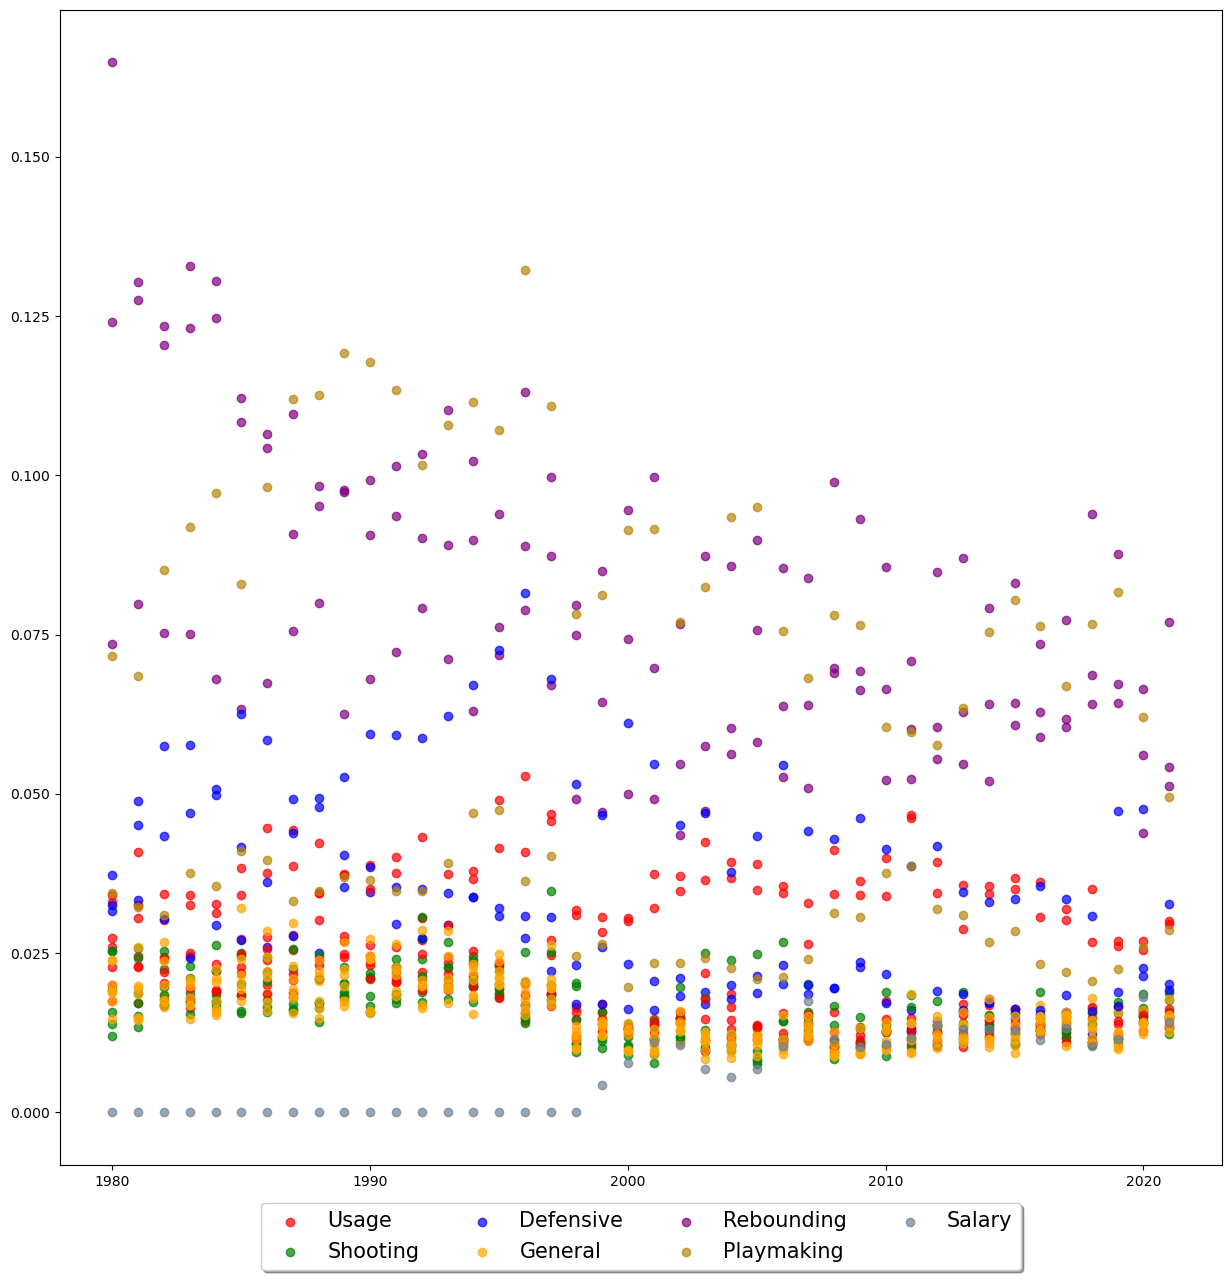

In [15]:
plt.figure(figsize=(15,15))

for idx in feature_importances.index:
    plt.scatter(feature_importances.columns, feature_importances.loc[idx], label=stats_mapper[idx], color=color_mapper[stats_mapper[idx]], alpha=0.7)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc='lower center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, prop={'size': 15})

plt.show()

# 3 training seasons

c:\Users\mathe\anaconda3\Lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


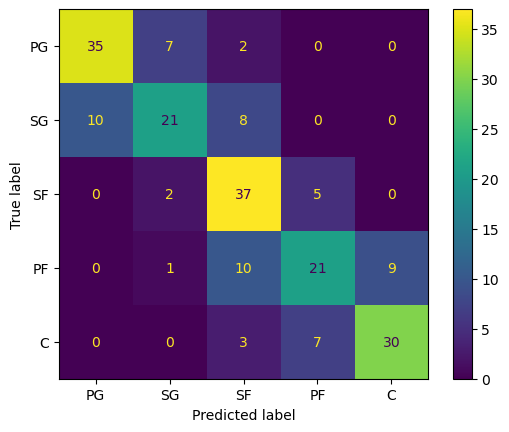

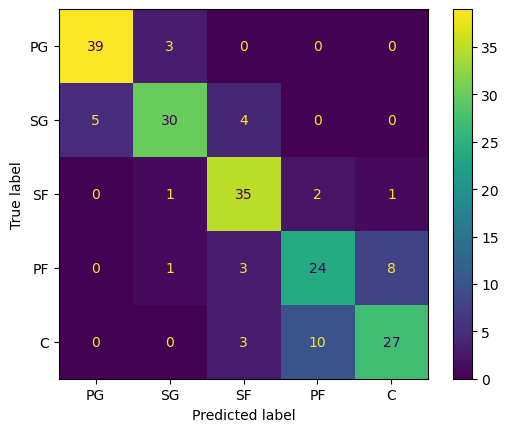

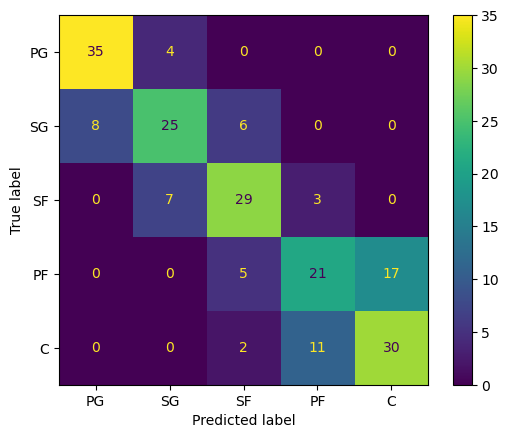

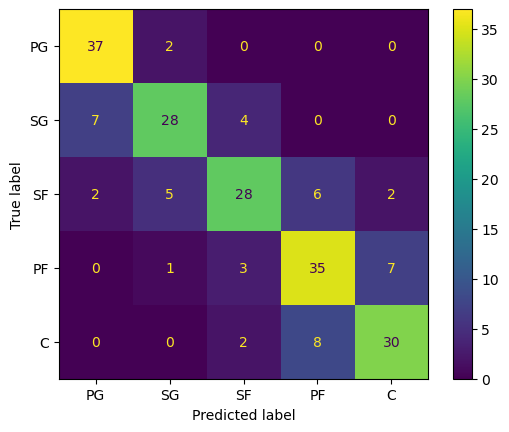

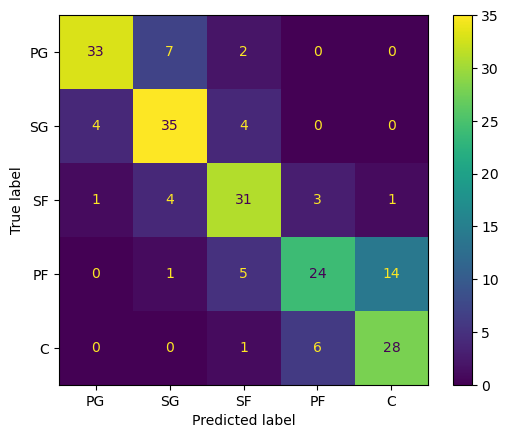

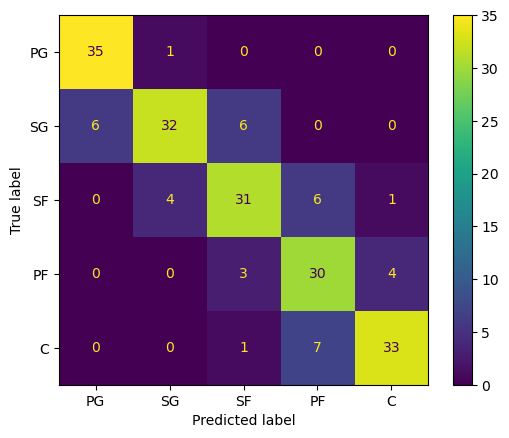

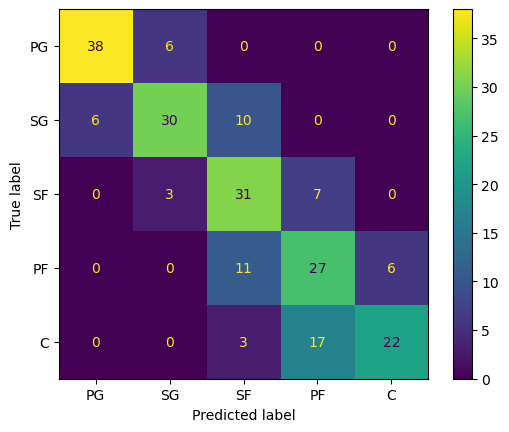

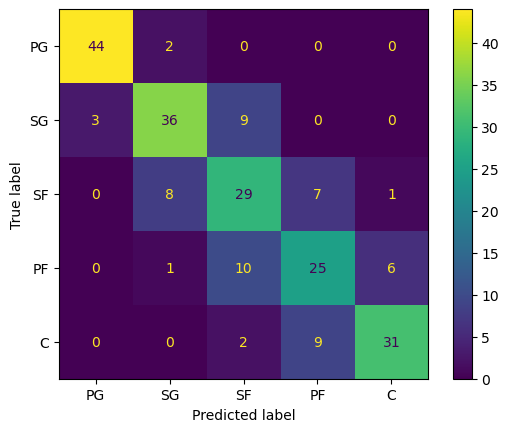

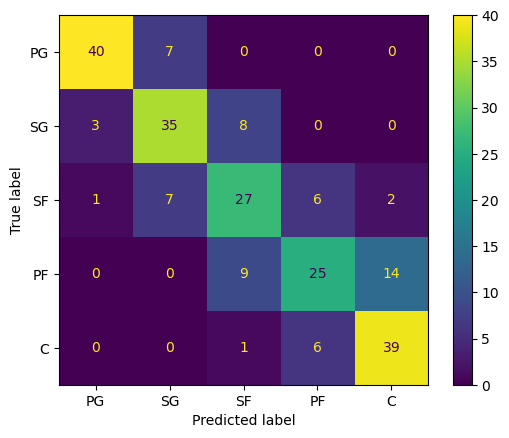

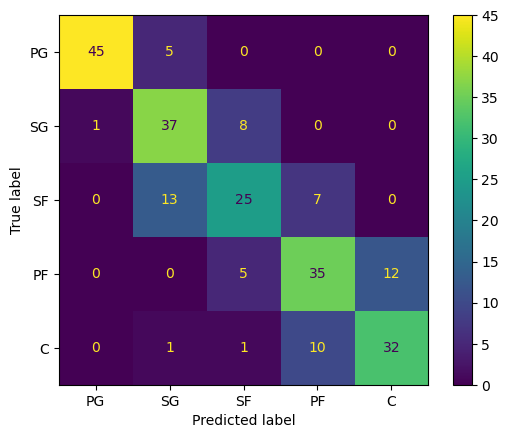

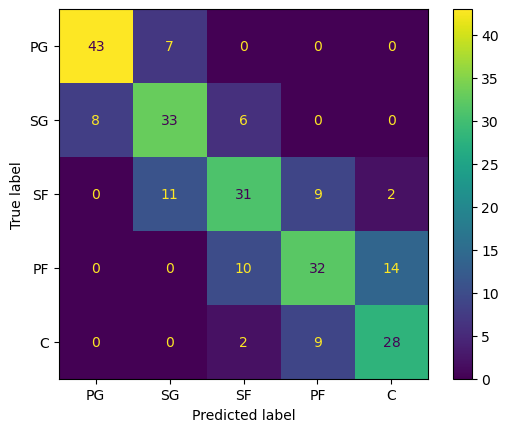

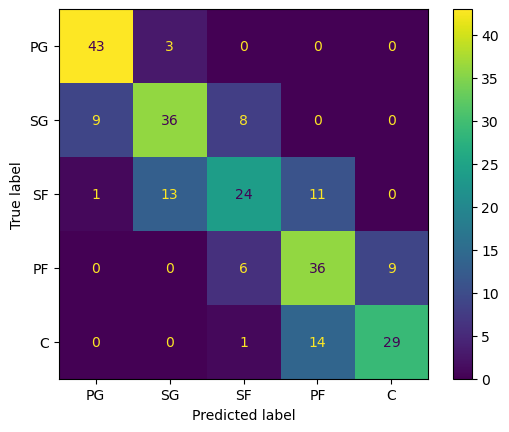

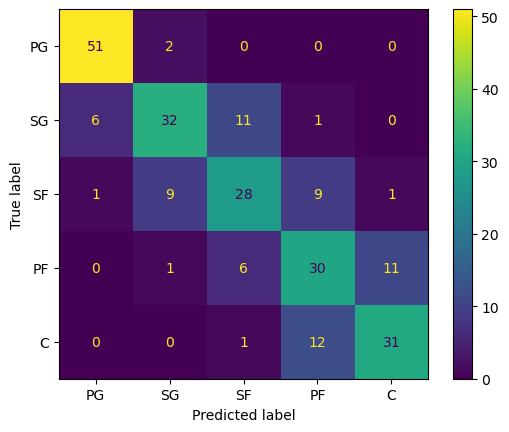

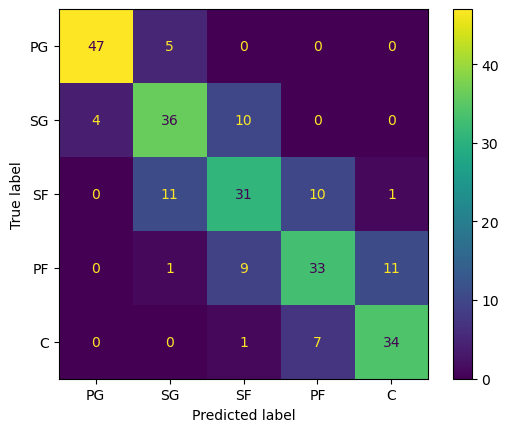

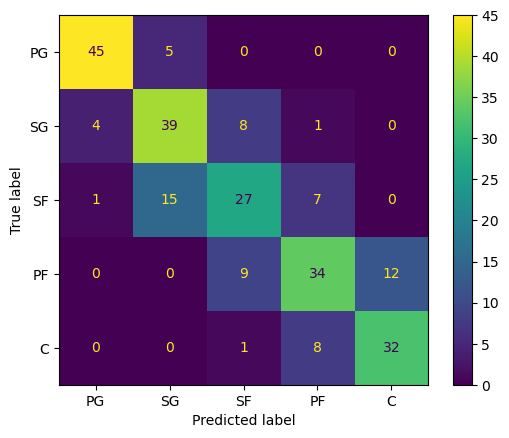

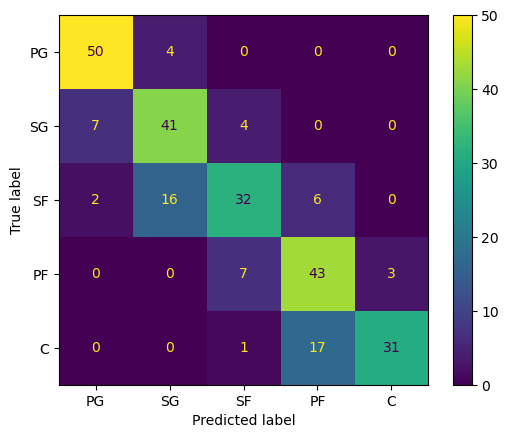

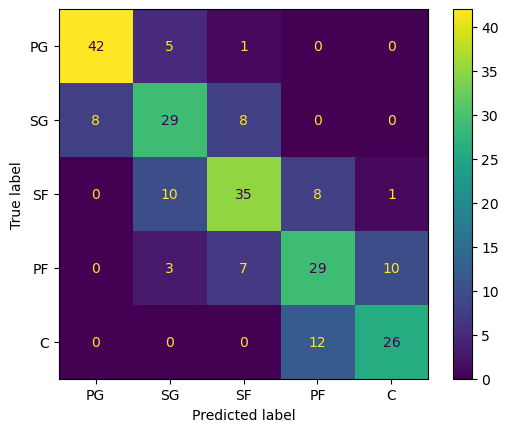

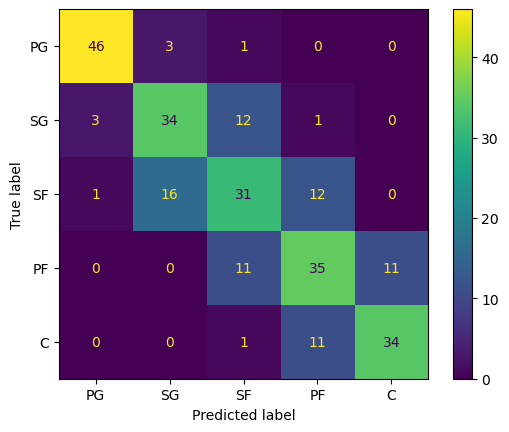

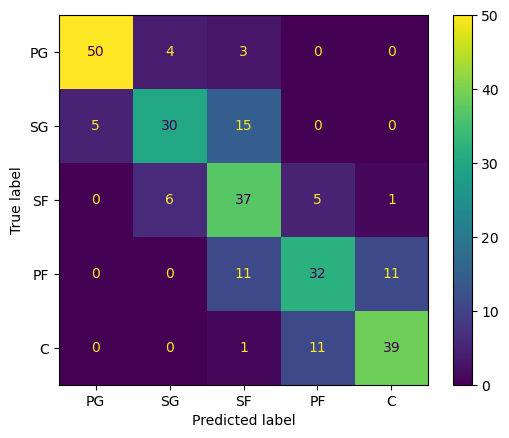

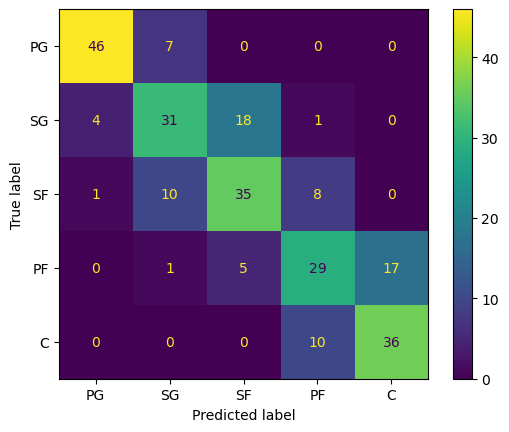

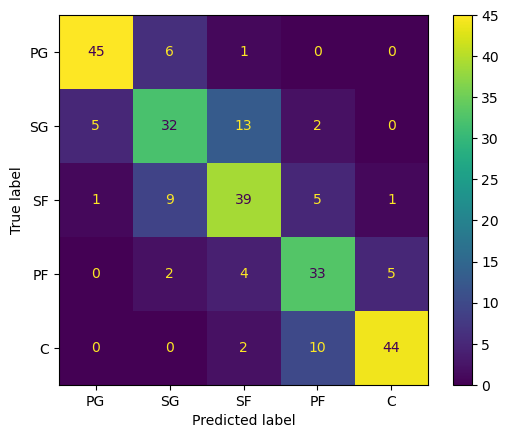

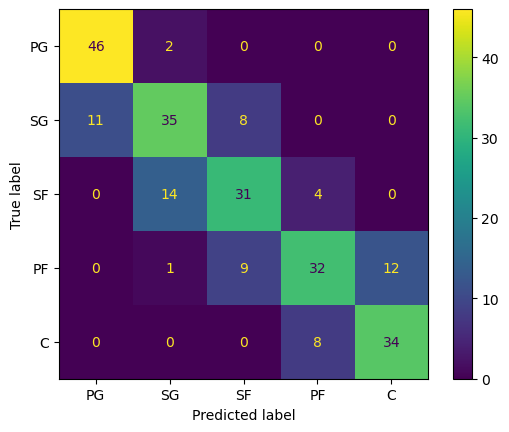

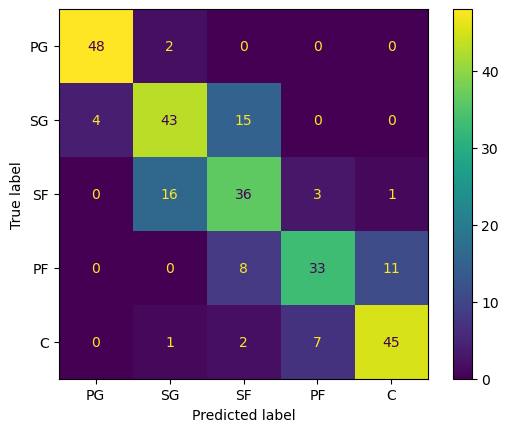

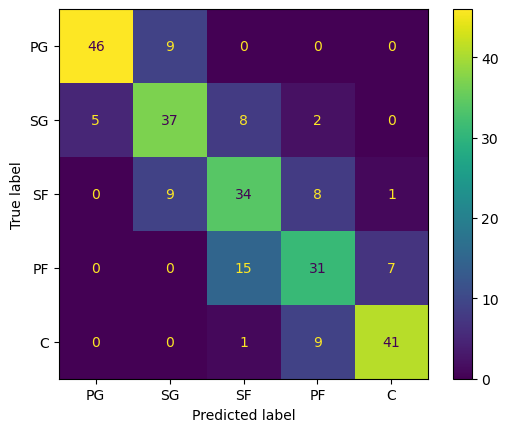

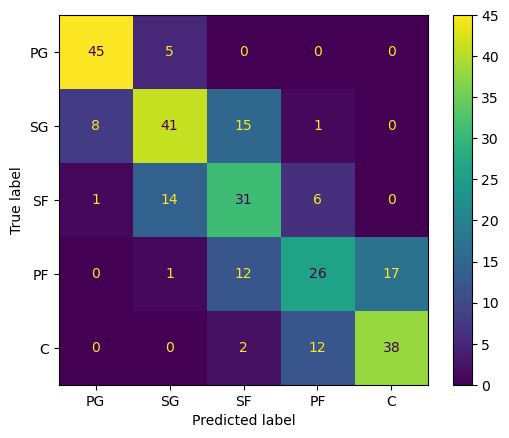

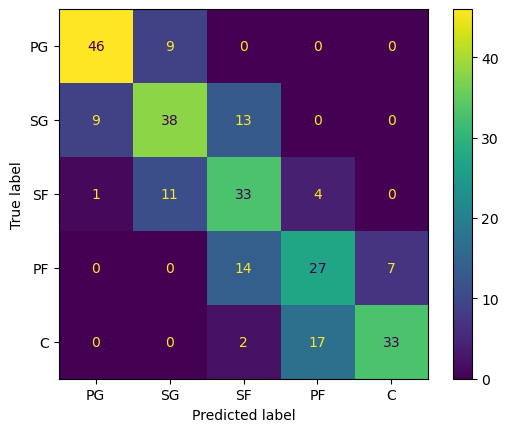

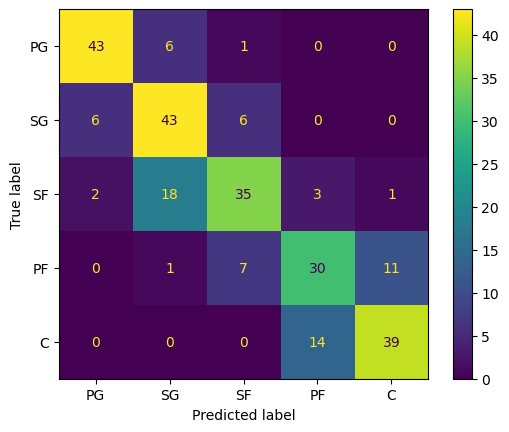

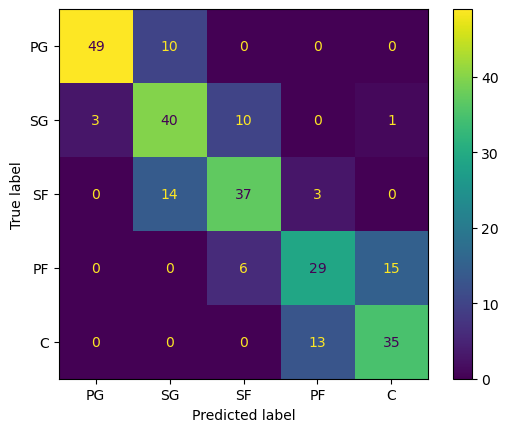

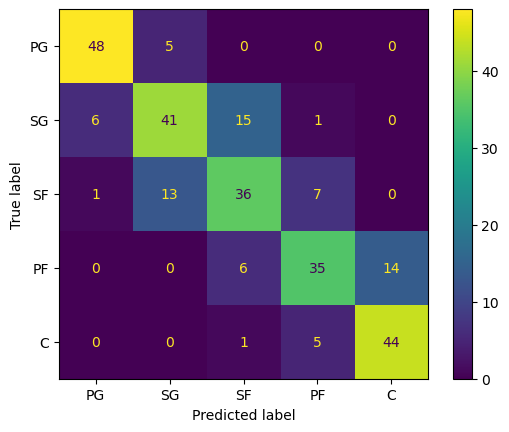

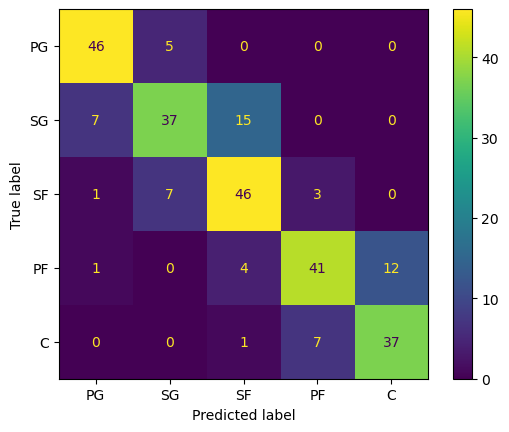

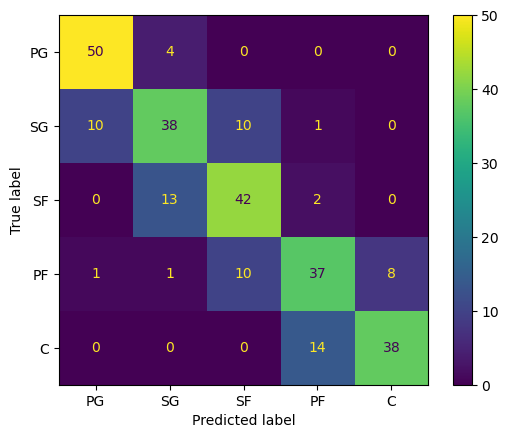

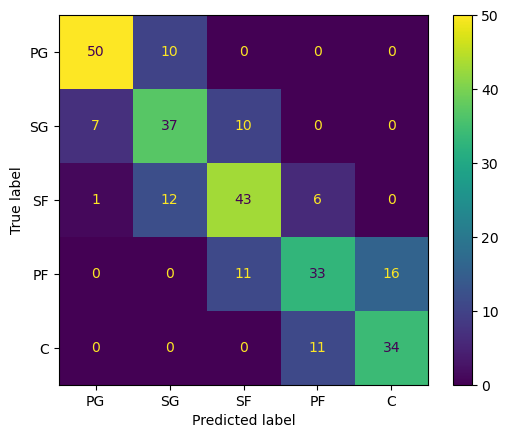

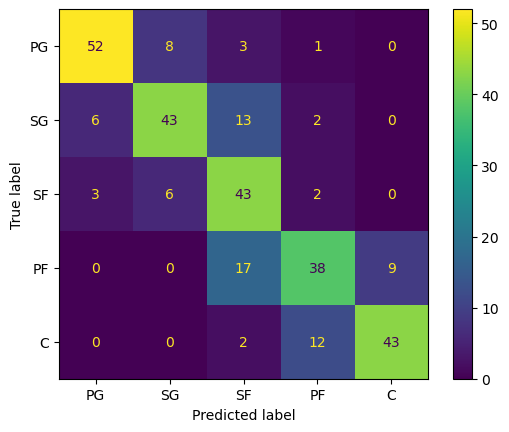

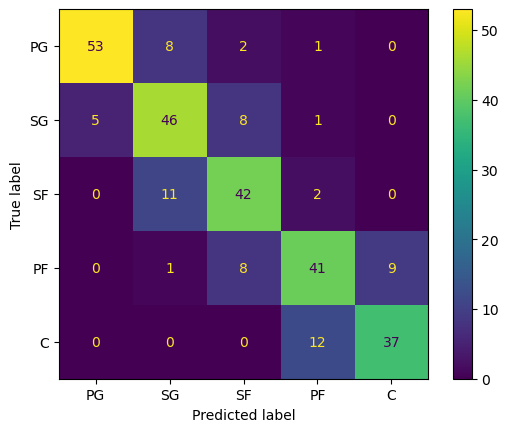

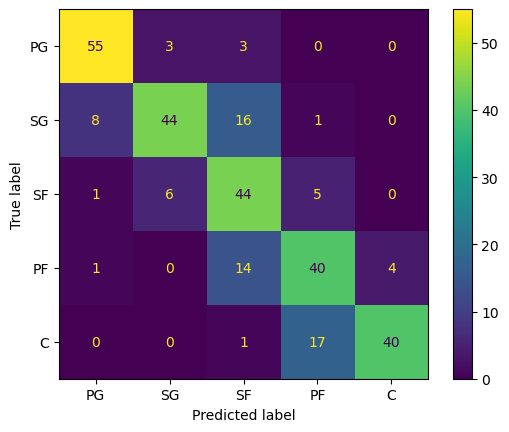

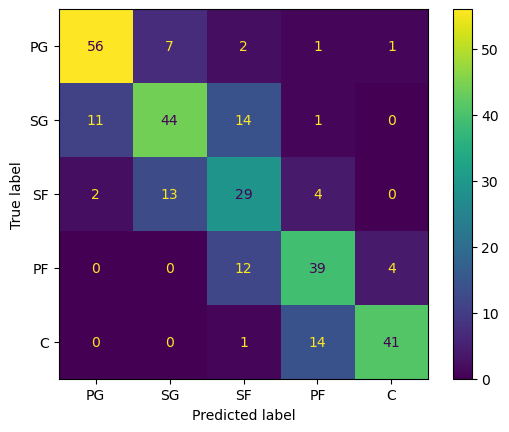

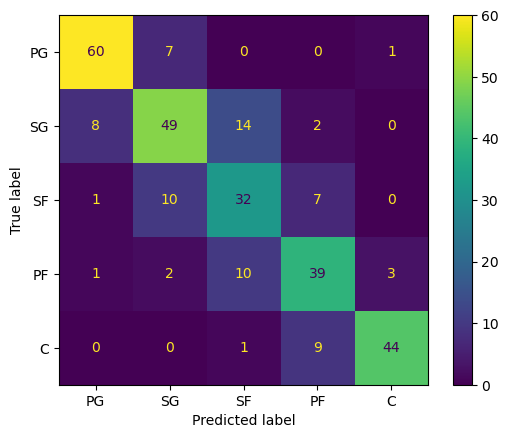

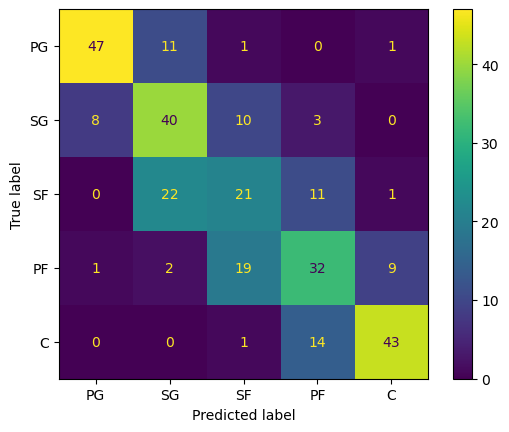

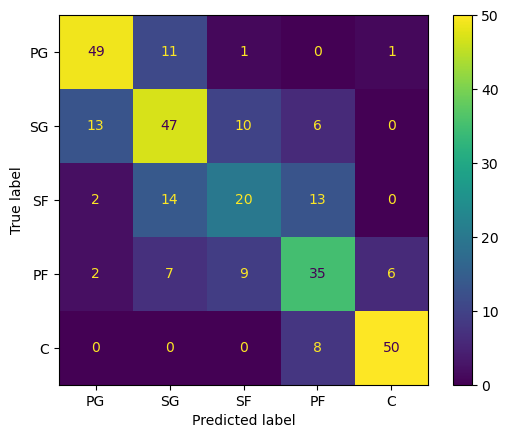

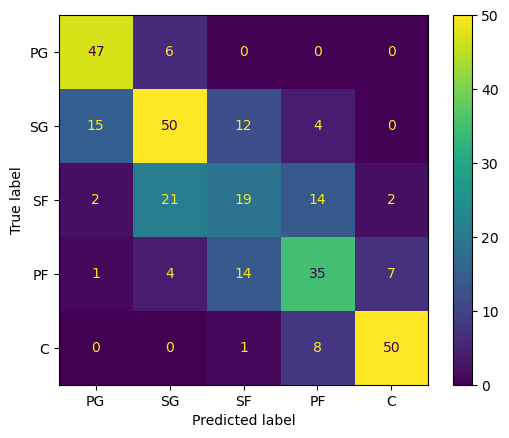

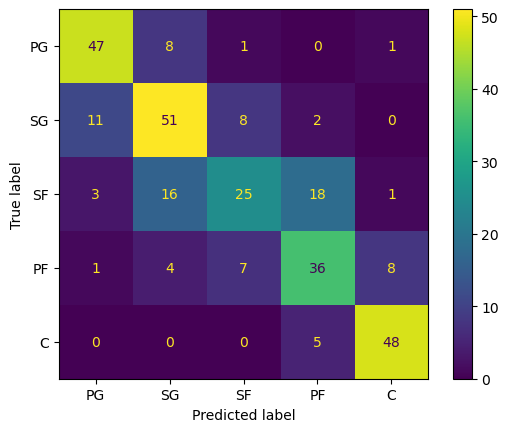

In [16]:
entropies_df, scores, feature_importances = classify_year_by_year(range(1980, 2021), 3)

<Axes: >

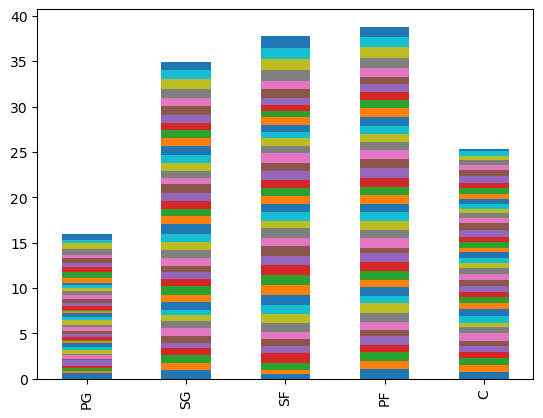

In [17]:
entropies_df.plot(kind='bar', stacked=True, legend=False)

<Axes: >

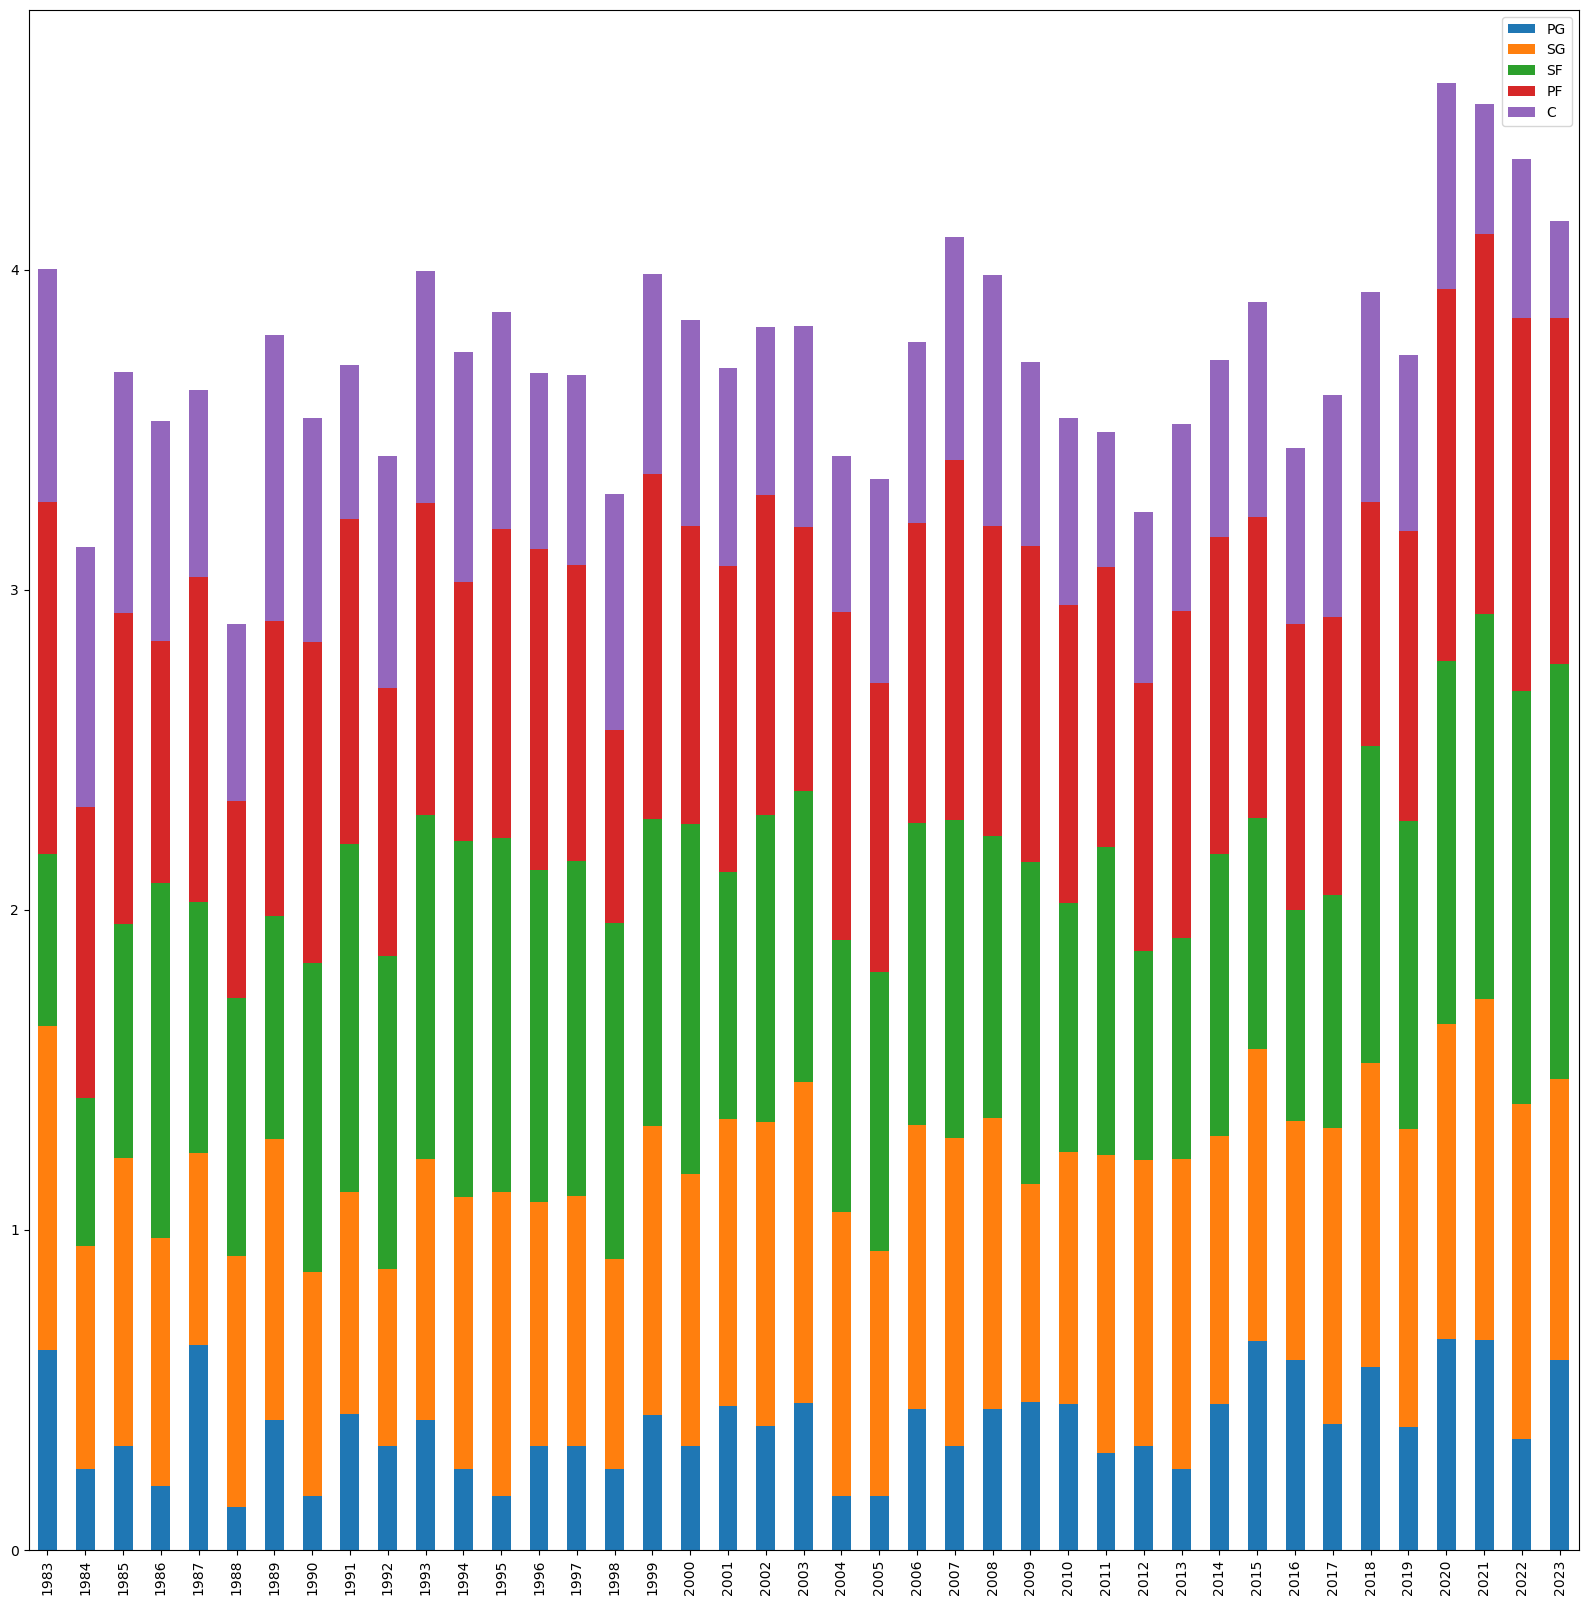

In [18]:
entropies_df.transpose().plot(kind='bar', stacked=True, figsize=(20,20))

<Axes: >

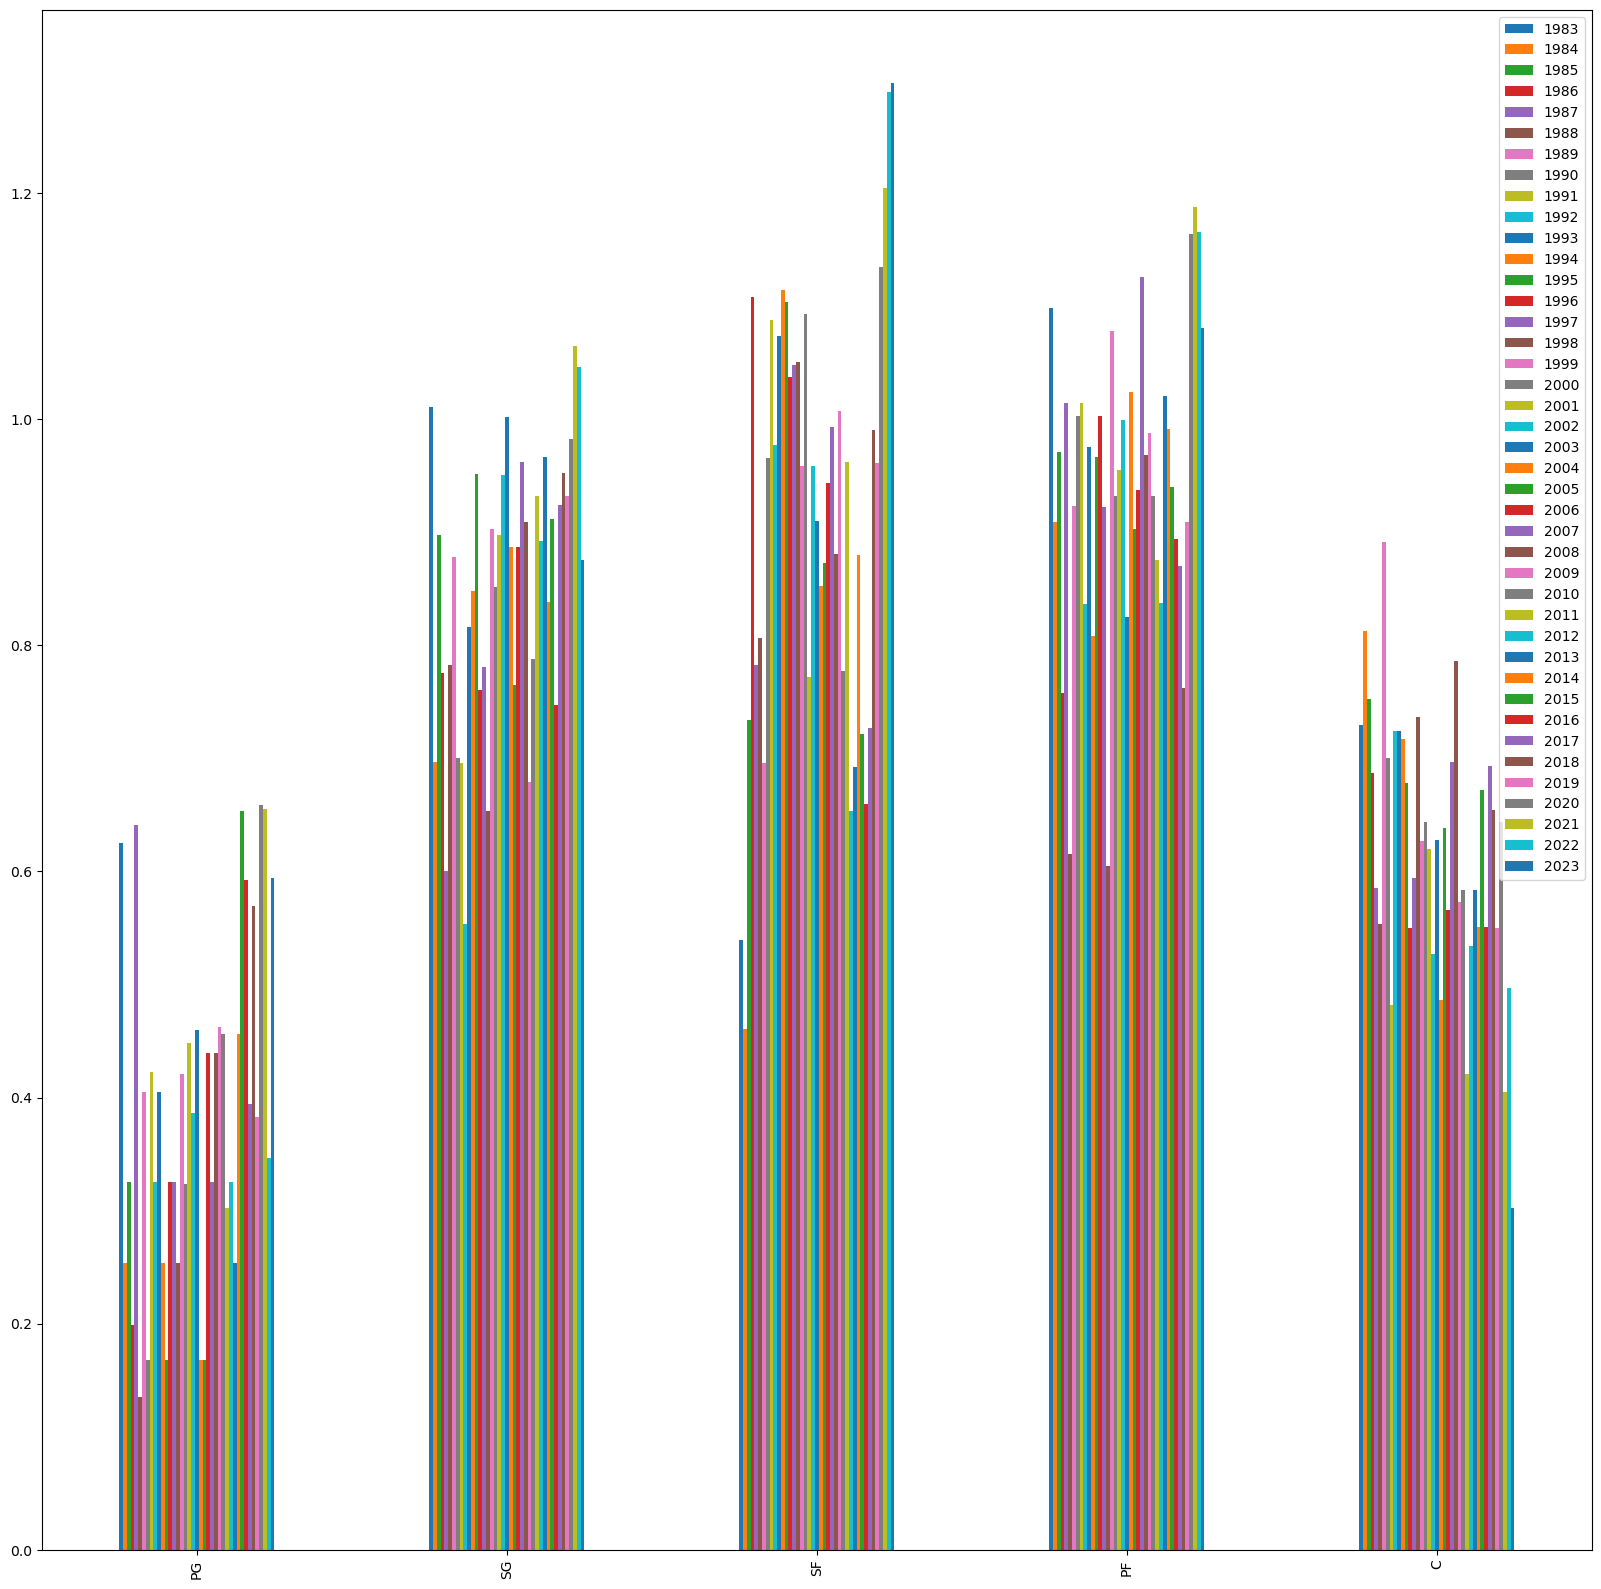

In [19]:
entropies_df.plot(kind='bar', figsize=(20,20))

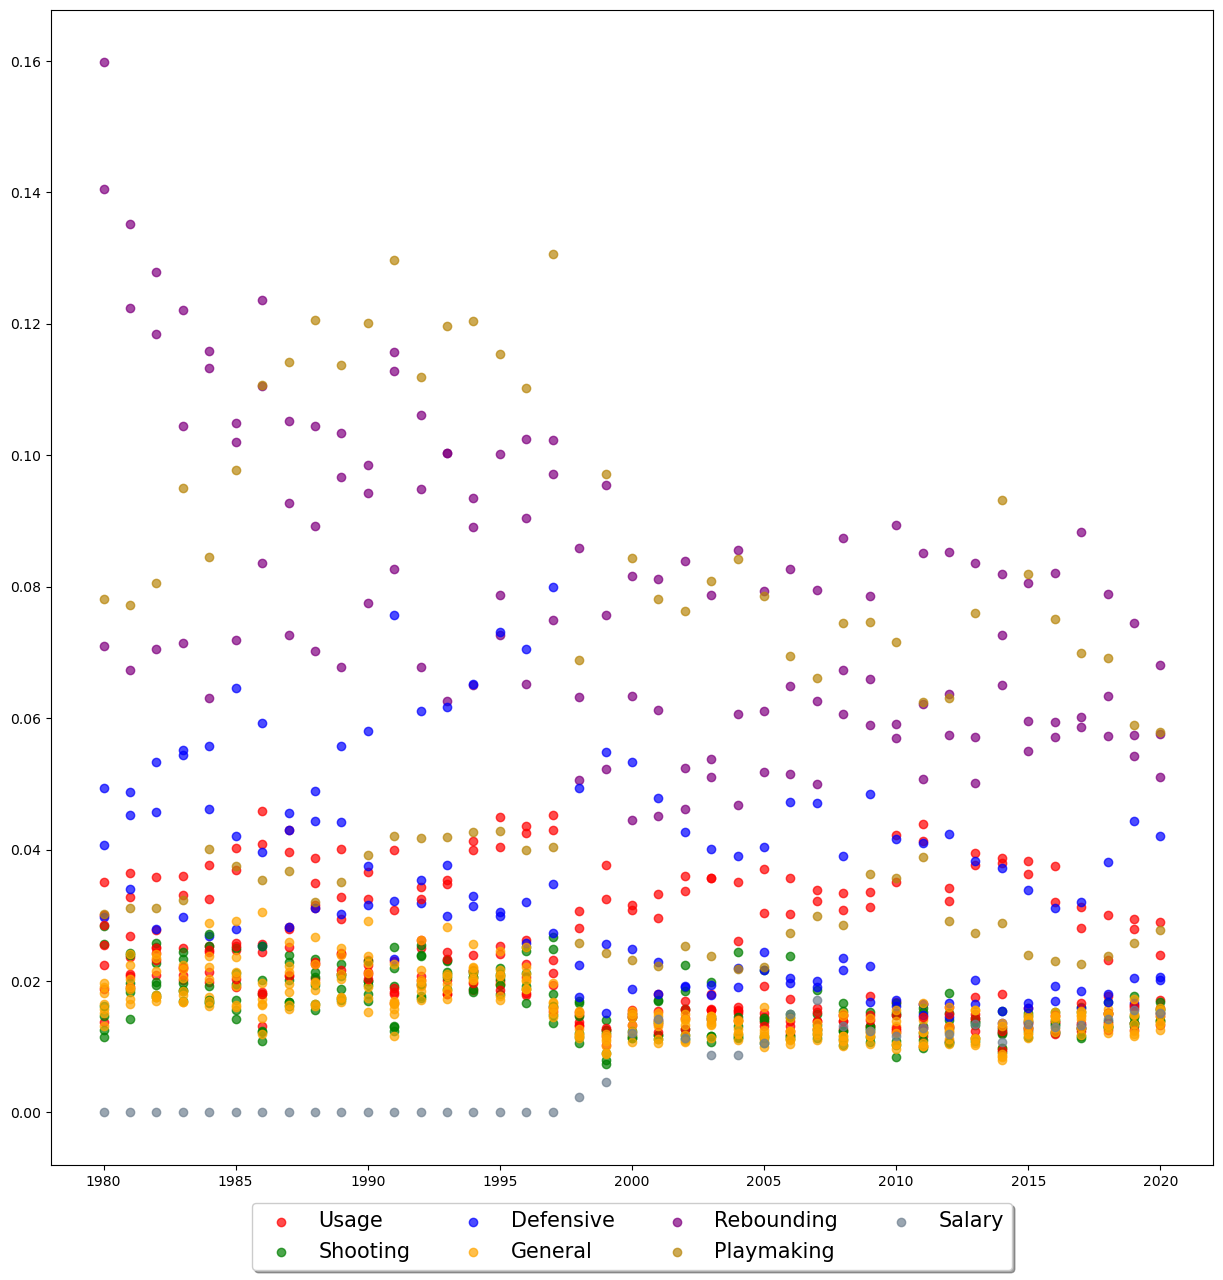

In [20]:
plt.figure(figsize=(15,15))

for idx in feature_importances.index:
    plt.scatter(feature_importances.columns, feature_importances.loc[idx], label=stats_mapper[idx], color=color_mapper[stats_mapper[idx]], alpha=0.7)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc='lower center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, prop={'size': 15})

plt.show()

# 4 training seasons

In [10]:
scores, accuracies, confusion_matrices = classify_year_by_year(range(1980, 2021))

In [29]:
def lowess_with_confidence_bounds(
    x, y, eval_x, N=200, conf_interval=0.99, lowess_kw=None
):
    """
    
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    
    """
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Perform bootstrap resamplings of the data
    # and  evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]

        smoothed_values[i] = sm.nonparametric.lowess(
            exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw
        )

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top

In [14]:
deltas = []
accuracies_list = []

# Calculate Delta for each cell
for row in accuracies.index:
    for col in accuracies.columns:
        if pd.notna(accuracies.loc[row, col]):
            training_seasons = [row, row + 1, row + 2, row + 3]
            closest_training_season = min(training_seasons, key=lambda x: abs(x - col))
            delta = col - closest_training_season
            deltas.append(delta)
            accuracies_list.append(accuracies.loc[row, col])

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'Delta': deltas, 'Accuracy': accuracies_list})


In [34]:
smoothed = sm.nonparametric.lowess(plot_df['Accuracy'], plot_df['Delta'], frac=0.1)

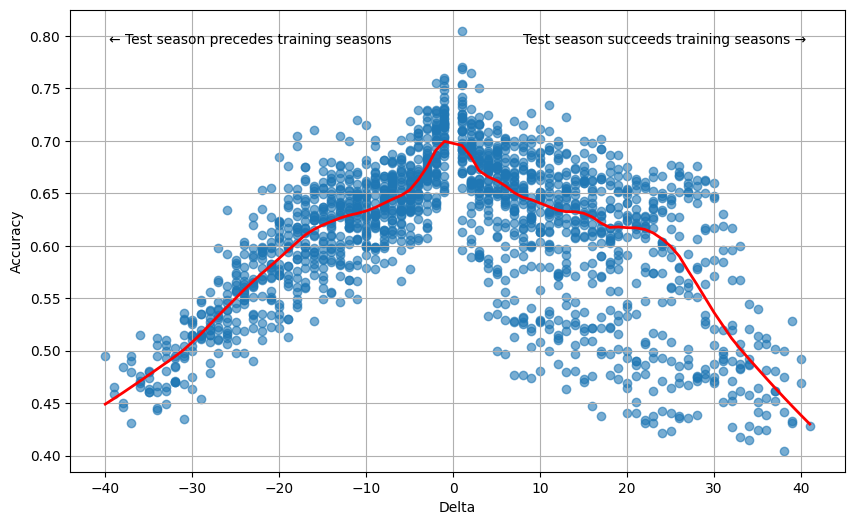

In [35]:

# Plot the scatter chart
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['Delta'], plot_df['Accuracy'], alpha=0.6)
plt.xlabel('Delta')
plt.ylabel('Accuracy')
plt.grid(True)

plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2)


plt.annotate('← Test season precedes training seasons', xy=(0.05, 0.95), xycoords='axes fraction',
             horizontalalignment='left', verticalalignment='top', fontsize=10, color='black')
plt.annotate('Test season succeeds training seasons →', xy=(0.95, 0.95), xycoords='axes fraction',
             horizontalalignment='right', verticalalignment='top', fontsize=10, color='black')

plt.show()

### Matrix de distribuição com base no total da temporada

In [12]:
distribution_matrices = []

for season, matrix in confusion_matrices.items():
    total = np.sum(matrix)
    distribution_matrix = matrix / total
    distribution_matrices.append(distribution_matrix)

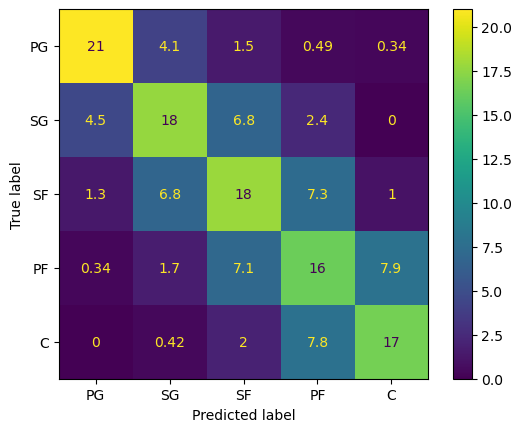

In [13]:
final_matrix = np.zeros_like(distribution_matrices[0])

# Accumulate the matrices by taking the maximum value for each cell
for distribution_matrix in distribution_matrices:
    final_matrix = np.maximum(final_matrix, distribution_matrix)

final_matrix = final_matrix * 100

ConfusionMatrixDisplay(final_matrix, display_labels=["PG", "SG", "SF", "PF", "C"]).plot() 

### Matriz de distribuição com base na posição verdadeira

In [14]:
distribution_matrices = []

for season, matrix in confusion_matrices.items():
    row_sums = matrix.sum(axis=1, keepdims=True)
    distribution_matrix = matrix / row_sums
    distribution_matrices.append(distribution_matrix)

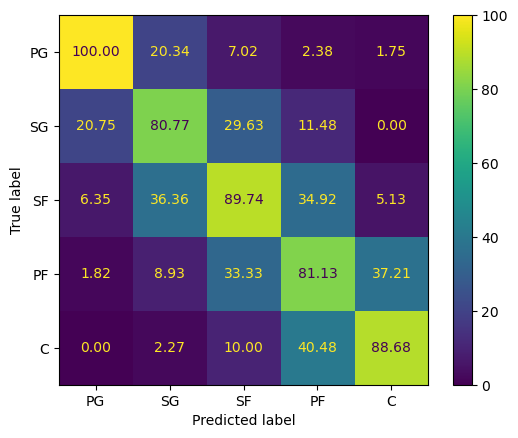

In [15]:
final_matrix = np.zeros_like(distribution_matrices[0])

# Accumulate the matrices by taking the maximum value for each cell
for distribution_matrix in distribution_matrices:
    final_matrix = np.maximum(final_matrix, distribution_matrix)

final_matrix = final_matrix * 100

ConfusionMatrixDisplay(final_matrix, display_labels=["PG", "SG", "SF", "PF", "C"]).plot(values_format=".2f") 

In [16]:
from itertools import combinations

def find_submatrices(final_matrix, size, minimum_threshold):
    labels = ["PG", "SG", "SF", "PF", "C"]
    n = len(final_matrix)
    valid_submatrices = set()

    # Generate all combinations of indices
    indices = list(range(n))
    for comb in combinations(indices, size):
        submatrix = final_matrix[np.ix_(comb, comb)]
        if np.all(submatrix > minimum_threshold):
            positions = [labels[i] for i in comb]
            if len(positions) == len(set(positions)):
                positions = sorted(positions)
                valid_submatrices.add(tuple(positions))
    
    return list(valid_submatrices)

In [17]:
import nbformat
from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell

In [18]:
with open("NullHypothesisClassifier.ipynb", "r") as f:
    notebook = nbformat.read(f, as_version=4)

# Create an interactive shell
shell = InteractiveShell.instance()

# Execute each cell in the notebook
for cell in notebook.cells:
    if cell.cell_type == 'code':
        shell.run_cell(cell.source)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


In [19]:
transposed_entropies = entropies_df.transpose()
positionless_markers = {}

for i, row in transposed_entropies.iterrows():
    positionless_markers[i] = {}
    for position in POSITIONS:
        if row[position] > positionless_borderlines[i][position]:
            positionless_markers[i][position] = True
        else:
            positionless_markers[i][position] = False

In [21]:
transposed_entropies

,PG,SG,SF,PF,C
1984,0.253639,0.786320,0.460450,0.905264,0.730588
1985,0.513482,0.861552,0.733540,1.044644,0.724335
1986,0.278769,0.733540,1.005059,0.867887,0.716634
1987,0.449669,0.784168,0.782598,1.103828,0.584944
1988,0.000000,0.733818,0.916531,0.703843,0.593928
1989,0.346515,0.855436,0.798938,0.923350,0.762843
1990,0.167944,0.772962,0.768756,1.089471,0.779347
1991,0.422709,0.659215,1.094366,0.869779,0.517462
1992,0.325083,0.553574,0.963094,0.826004,0.724245
1993,0.439670,0.843018,1.160346,1.000433,0.659701


In [26]:
positionless_borderlines[1980]['PF']

1.4197749338667236

In [24]:
positionless_groups = {}

for size in range(2, 6):
    submatrices = find_submatrices(final_matrix, size, 2.0)
    
    for submatrix in submatrices:
        positionless_groups[submatrix] = {}
        for i, row in transposed_entropies.iterrows():
            cumulative_null_hypothesis_entropy = sum([positionless_borderlines[i][position] for position in submatrix])
            print(submatrix)
            print(cumulative_null_hypothesis_entropy)
            cumulative_predicted_entropy = sum([row[position] for position in submatrix])
            print(cumulative_predicted_entropy)
            
            if cumulative_predicted_entropy > cumulative_null_hypothesis_entropy:
                positionless_groups[submatrix][i] = True
            else:
                positionless_groups[submatrix][i] = False
                
positionless_groups 
        

('C', 'PF')
2.858334129951555
1.635851642029684
('C', 'PF')
2.8902505949979913
1.7689787283551919
('C', 'PF')
2.905053635681492
1.5845207286297596
('C', 'PF')
2.865461797931162
1.6887725929232689
('C', 'PF')
2.8576609483211017
1.2977712313259406
('C', 'PF')
2.90387062299126
1.686193281540576
('C', 'PF')
2.8687081578449485
1.868817569235686
('C', 'PF')
2.9020140920129243
1.387240949137186
('C', 'PF')
2.946232432121623
1.5502497308634624
('C', 'PF')
2.91933559992448
1.660134495897519
('C', 'PF')
2.9423663083724367
1.5383376284953503
('C', 'PF')
2.9108642426435773
1.6420997954067427
('C', 'PF')
2.94352414476496
1.5271168426529527
('C', 'PF')
2.9498685578799666
1.4378280068403937
('C', 'PF')
2.946974074500449
1.4024309189560138
('C', 'PF')
2.9131033637367043
1.6652211823209726
('C', 'PF')
2.9328356500465724
1.5972362254639678
('C', 'PF')
2.97048233668145
1.7292120036085363
('C', 'PF')
2.9664241855413067
1.468817138996159
('C', 'PF')
2.9540040841965602
1.5705713239162844
('C', 'PF')
2.94250

{('C', 'PF'): {1984: False,
  1985: False,
  1986: False,
  1987: False,
  1988: False,
  1989: False,
  1990: False,
  1991: False,
  1992: False,
  1993: False,
  1994: False,
  1995: False,
  1996: False,
  1997: False,
  1998: False,
  1999: False,
  2000: False,
  2001: False,
  2002: False,
  2003: False,
  2004: False,
  2005: False,
  2006: False,
  2007: False,
  2008: False,
  2009: False,
  2010: False,
  2011: False,
  2012: False,
  2013: False,
  2014: False,
  2015: False,
  2016: False,
  2017: False,
  2018: False,
  2019: False,
  2020: False,
  2021: False,
  2022: False,
  2023: False,
  2024: False},
 ('C', 'SF'): {1984: False,
  1985: False,
  1986: False,
  1987: False,
  1988: False,
  1989: False,
  1990: False,
  1991: False,
  1992: False,
  1993: False,
  1994: False,
  1995: False,
  1996: False,
  1997: False,
  1998: False,
  1999: False,
  2000: False,
  2001: False,
  2002: False,
  2003: False,
  2004: False,
  2005: False,
  2006: False,
  2007: False

## Now let's find whether each combination fits the threshold for positionless

In [16]:
feature_importances = feature_importances.transpose()
mean_importances = feature_importances.mean()
mean_importances = mean_importances.sort_values(ascending=False)
filtered_indexes = mean_importances[mean_importances > 0.018].index.tolist()
print(filtered_indexes)


['TRB%', 'AST%', 'DRB%', 'ORB%', 'BLK%', '3PAr', '3PA', 'TOV%', 'STL%', 'PF', 'DBPM', 'FGA', '3P%', 'FTr', 'PTS']


<Axes: >

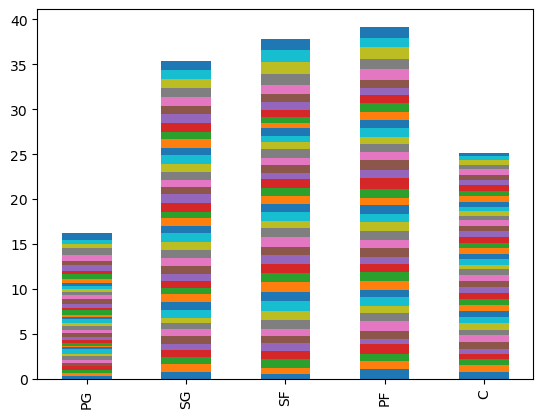

In [17]:
entropies_df.plot(kind='bar', stacked=True, legend=False)

<Axes: >

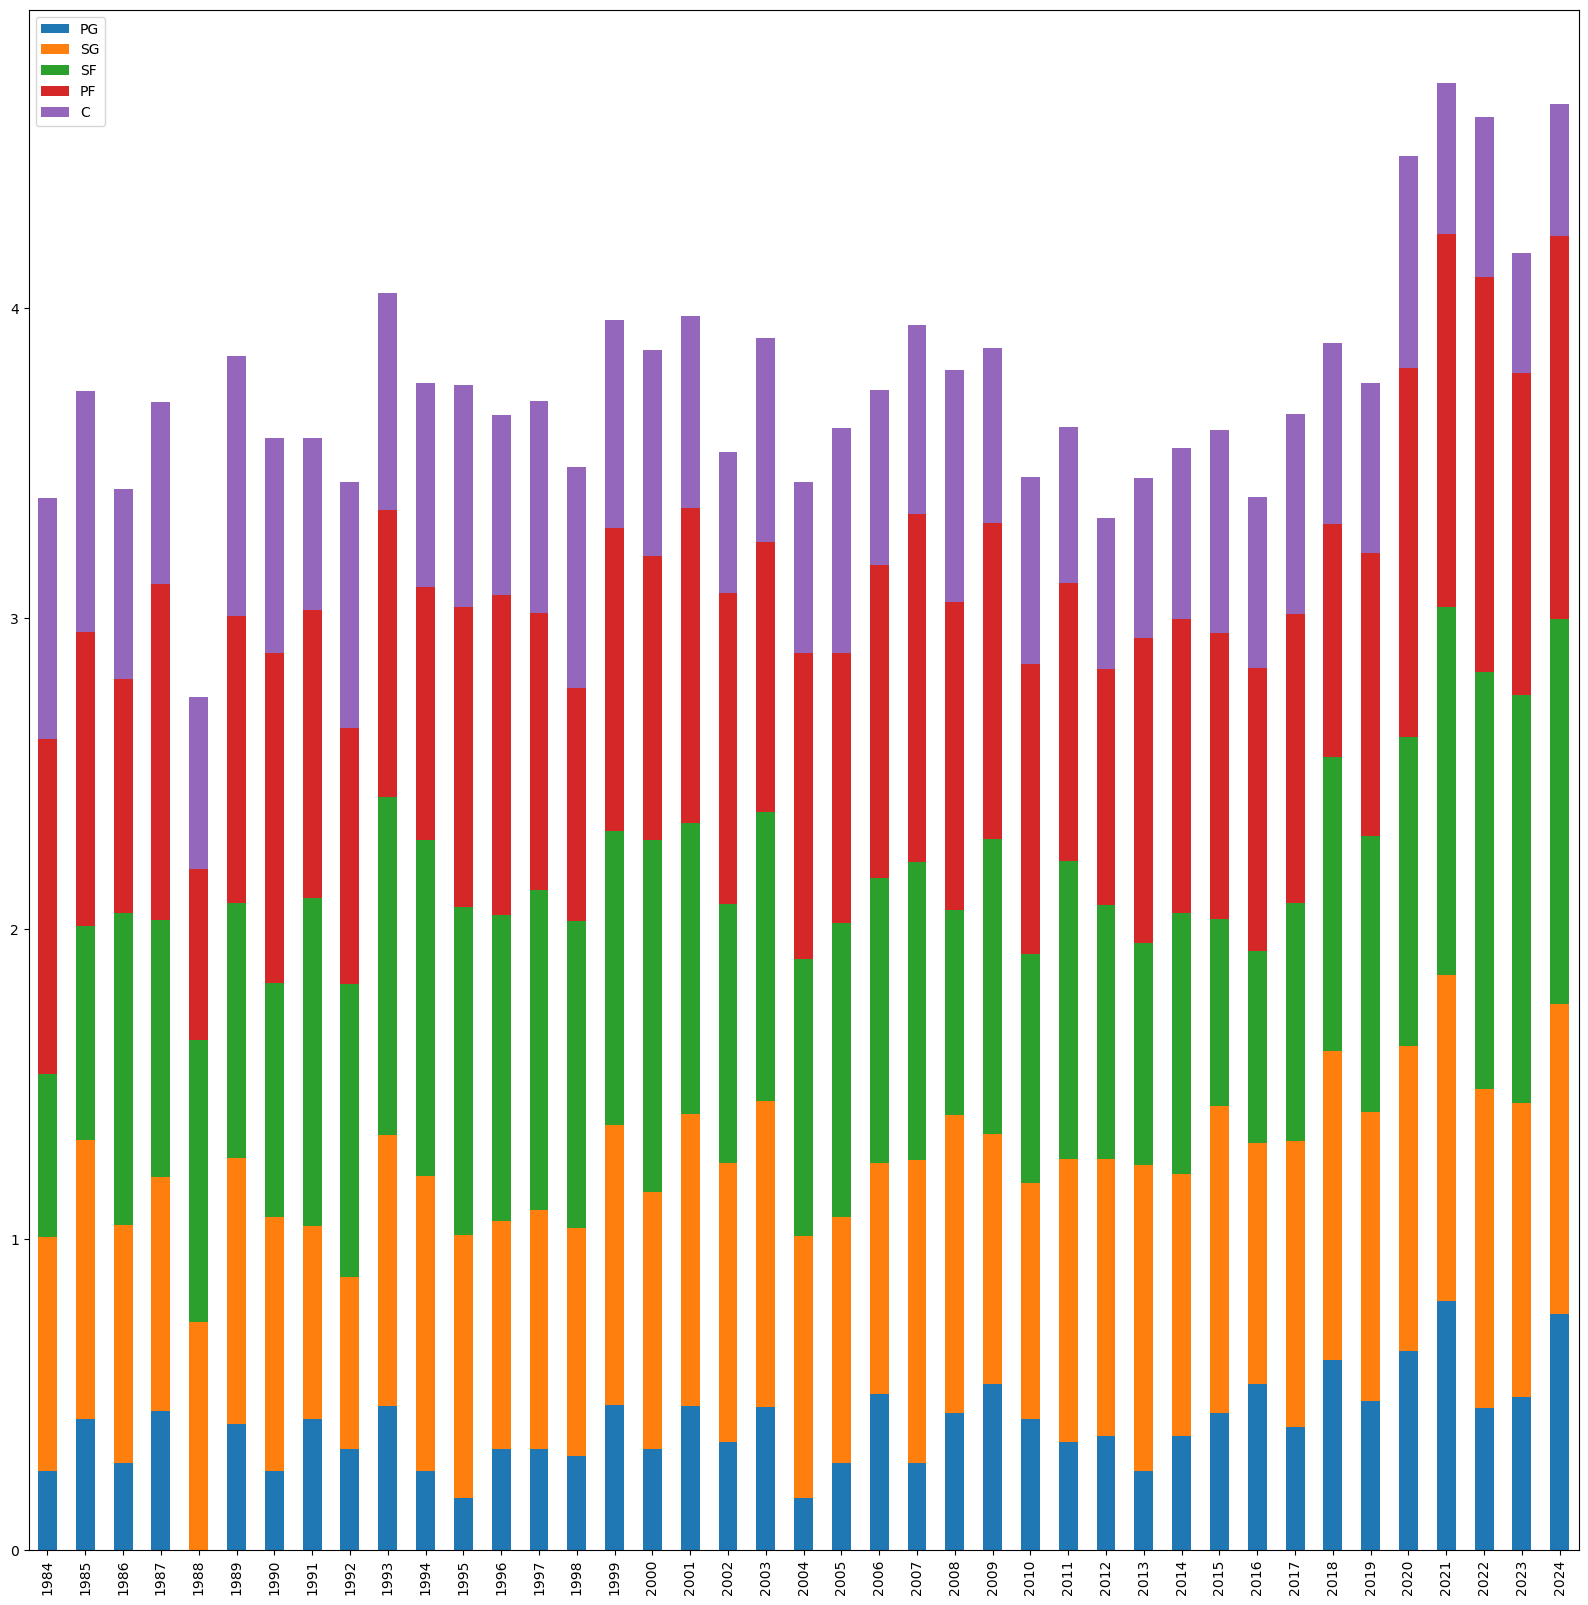

In [18]:
entropies_df.transpose().plot(kind='bar', stacked=True, figsize=(20,20))

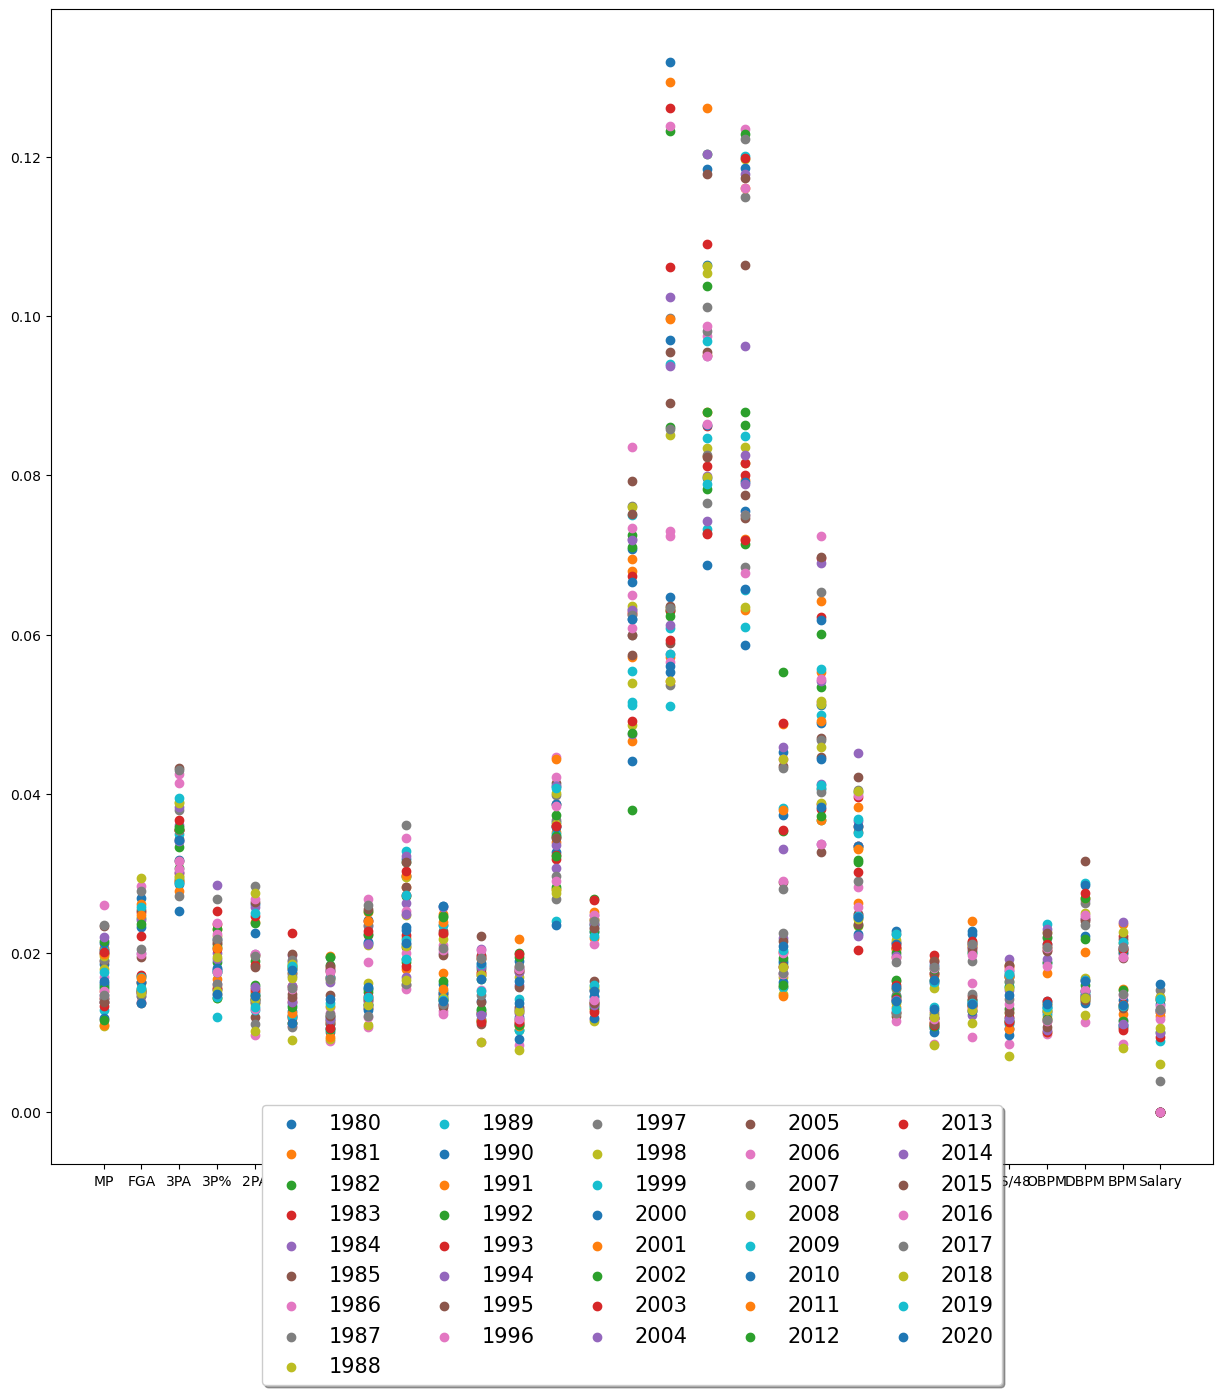

In [19]:
plt.figure(figsize=(15,15))

for idx in feature_importances.index:
    plt.scatter(feature_importances.columns, feature_importances.loc[idx], label=idx)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5, prop={'size': 15})

plt.show()

## Run NullHypothesis notebook to find positionless borderlines

In [20]:
import nbformat
from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell

In [25]:
with open("NullHypothesisClassifier.ipynb", "r") as f:
    notebook = nbformat.read(f, as_version=4)

# Create an interactive shell
shell = InteractiveShell.instance()

# Execute each cell in the notebook
for cell in notebook.cells:
    if cell.cell_type == 'code':
        shell.run_cell(cell.source)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


In [26]:
transposed_entropies = entropies_df.transpose()
positionless_markers = {}

for i, row in transposed_entropies.iterrows():
    positionless_markers[i] = {}
    for position in POSITIONS:
        if row[position] > positionless_borderlines[i][position]:
            positionless_markers[i][position] = True
        else:
            positionless_markers[i][position] = False

    

{1984: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1985: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1986: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1987: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1988: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1989: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1990: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1991: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1992: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1993: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1994: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1995: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1996: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1997: {'PG': False, 'SG': False, 'SF': False, 'PF'

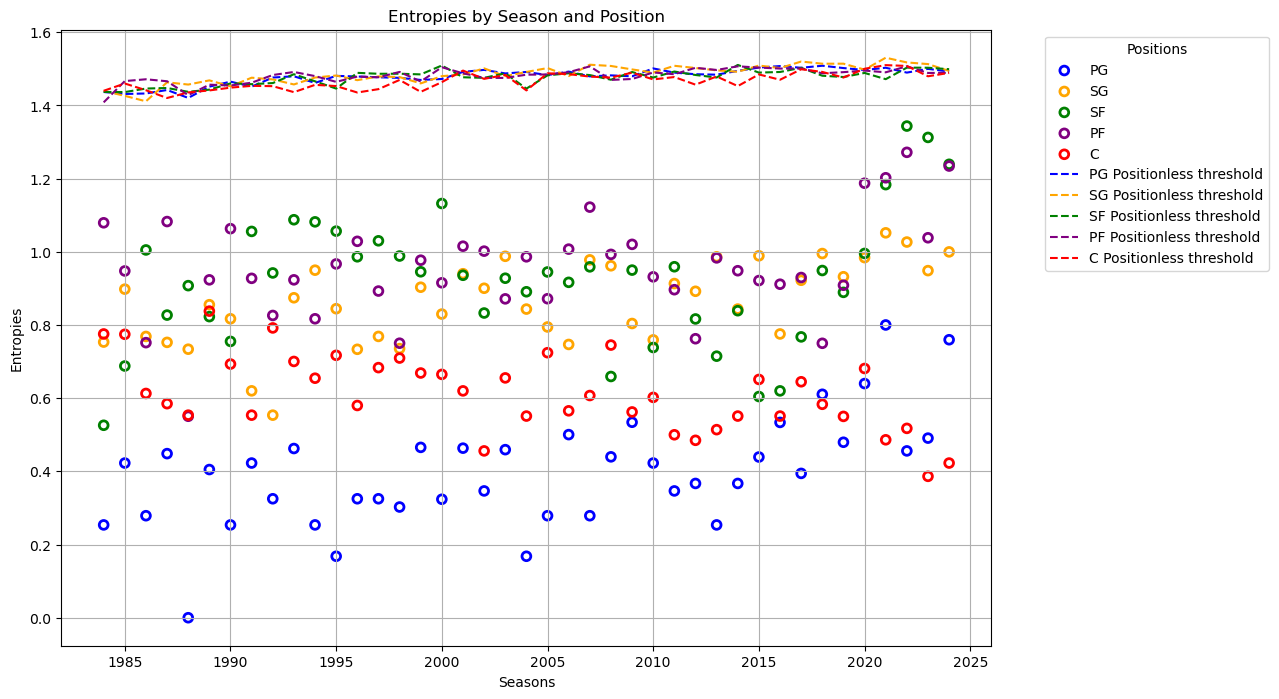

In [33]:
seasons = transposed_entropies.index
positions = transposed_entropies.columns

# Create the scatter plot
plt.figure(figsize=(12, 8))

for season in seasons:
    colors = {'PG': 'b', 'SG': 'orange', 'SF': 'g', 'PF': 'purple', 'C': 'r'}
    for position in positions:
        entropy = transposed_entropies.loc[season, position]
        fill_style = 'full' if positionless_markers[season][position] else 'none'
        
        plt.scatter(season, entropy, label=position, edgecolor=colors[position], facecolor=colors[position] if fill_style == 'full' else 'none', marker='o', s=40, lw=2)

for position in positions:
    borderlines = [positionless_borderlines[season][position] for season in seasons]
    plt.plot(seasons, borderlines, label=f'{position} Positionless threshold', color=colors[position], linestyle='--')

# Customize the plot
plt.xlabel('Seasons')
plt.ylabel('Entropies')
plt.title('Entropies by Season and Position')

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), title='Positions', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.show()

# 5 training seasons

c:\Users\mathe\anaconda3\Lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


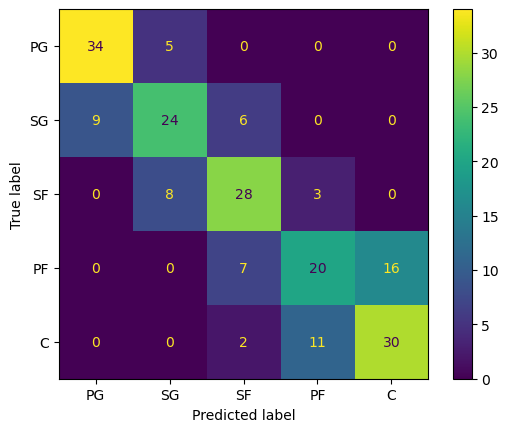

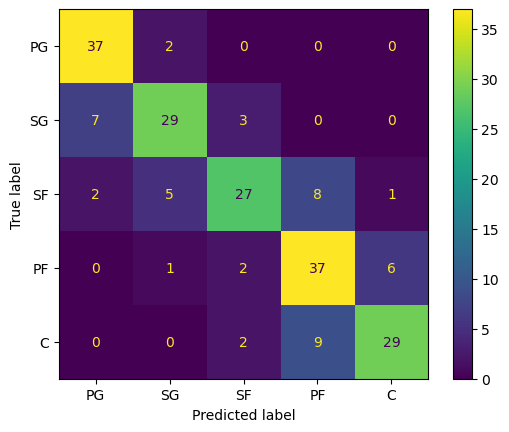

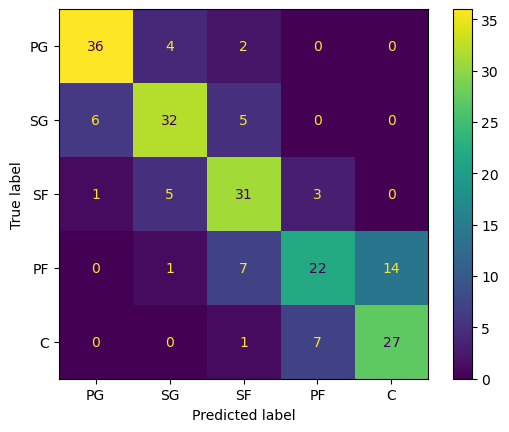

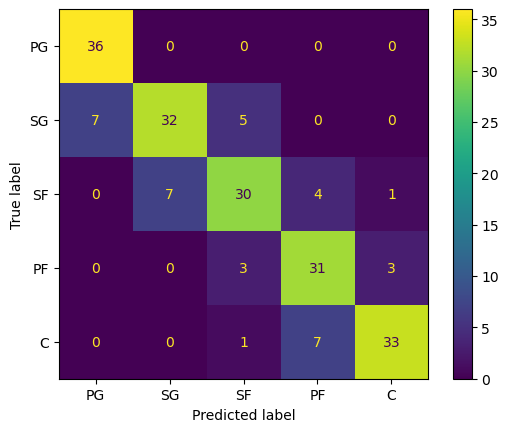

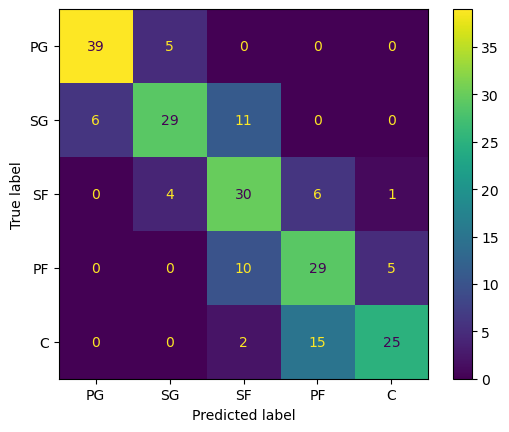

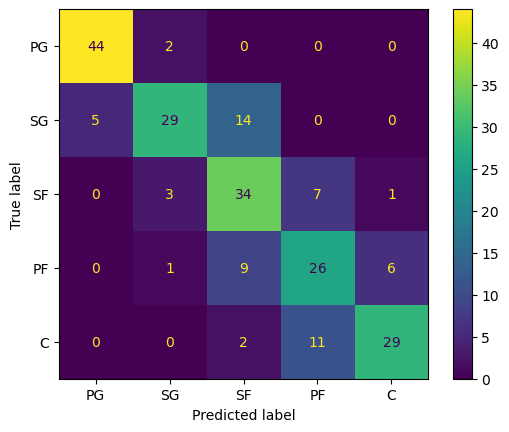

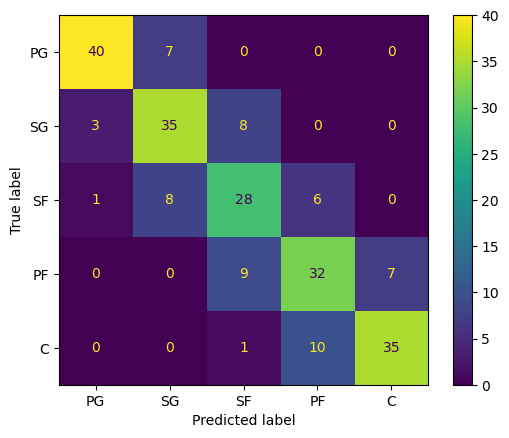

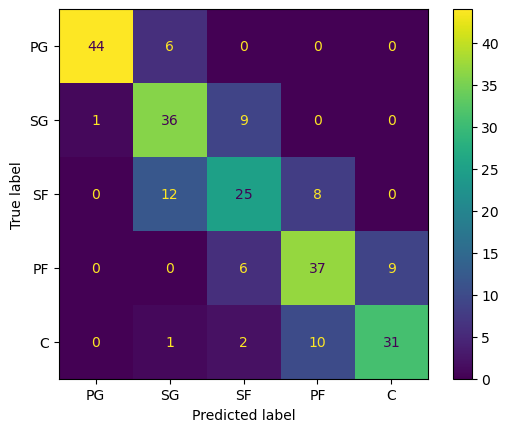

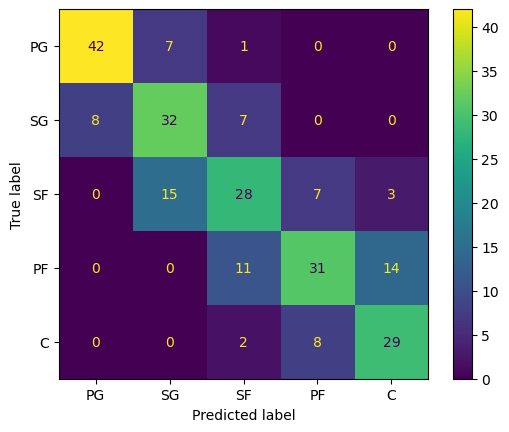

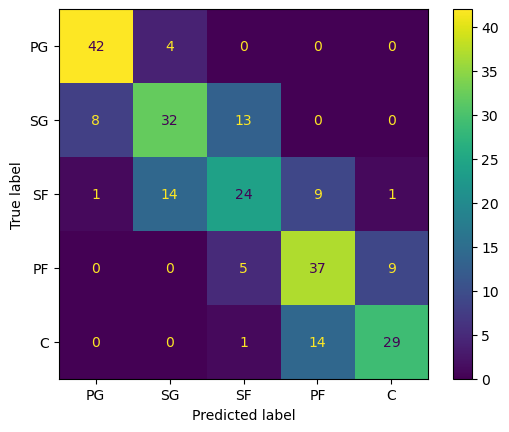

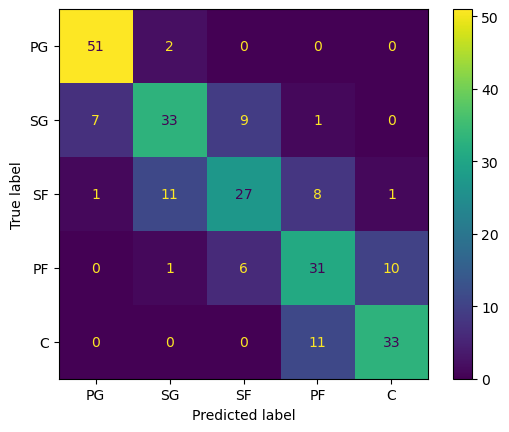

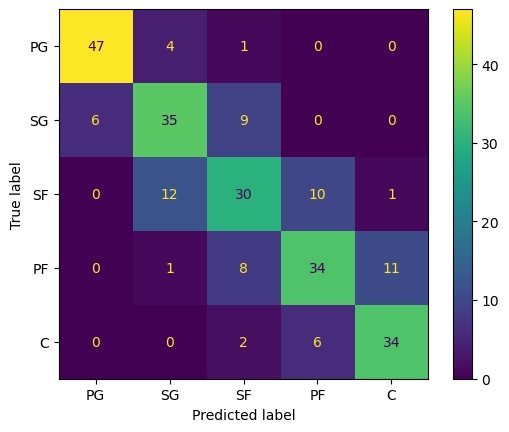

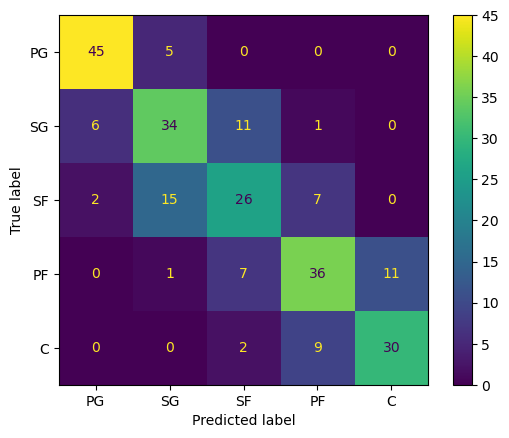

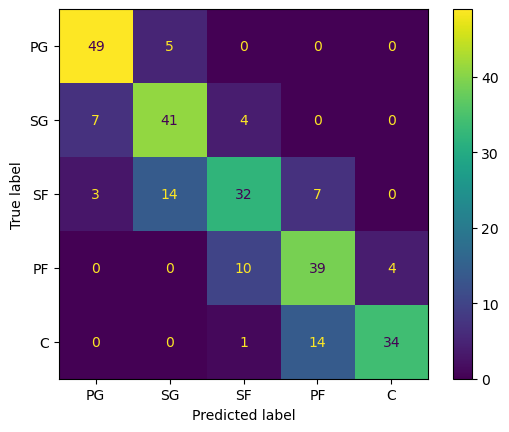

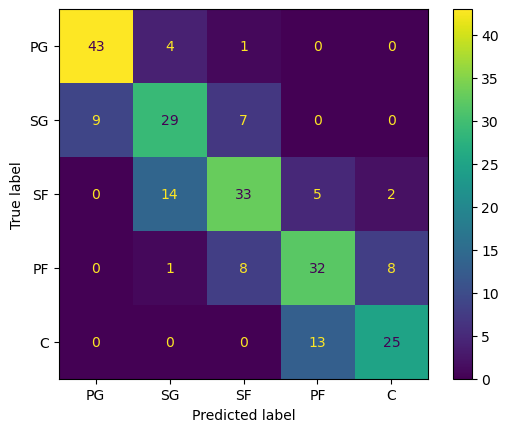

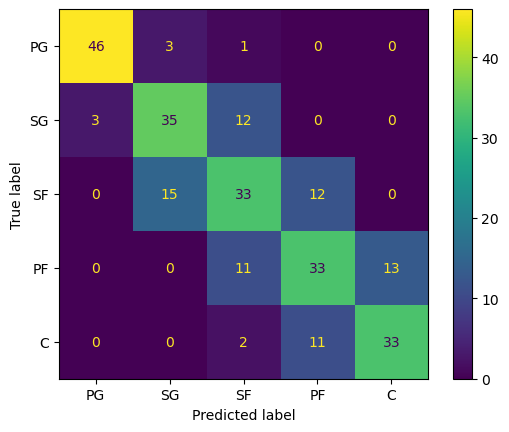

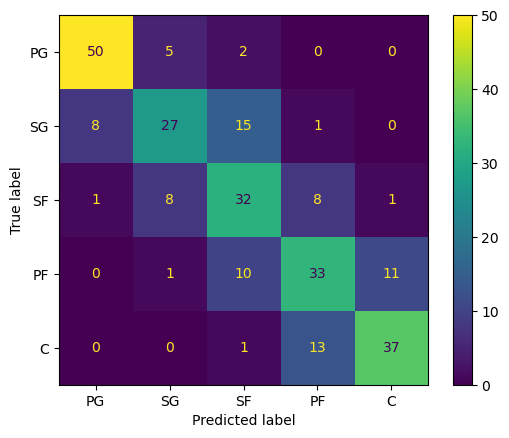

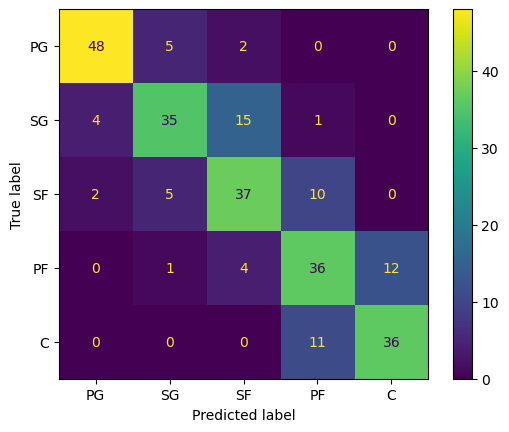

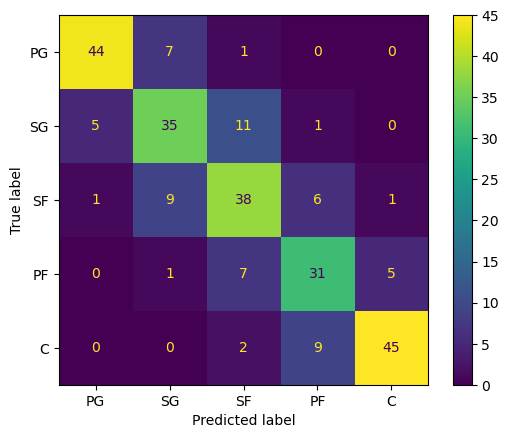

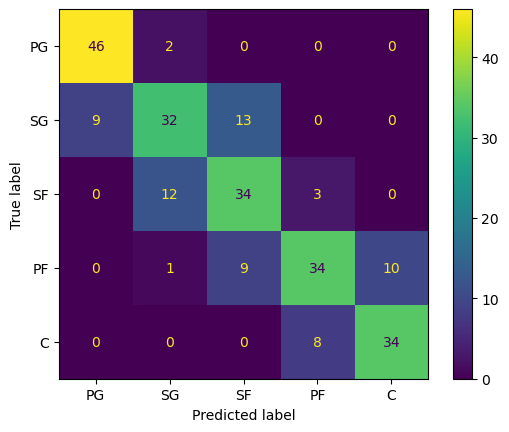

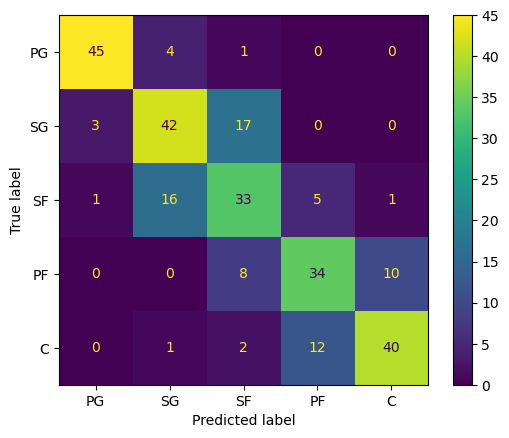

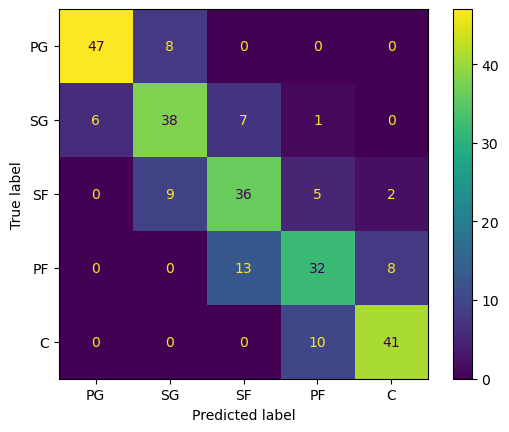

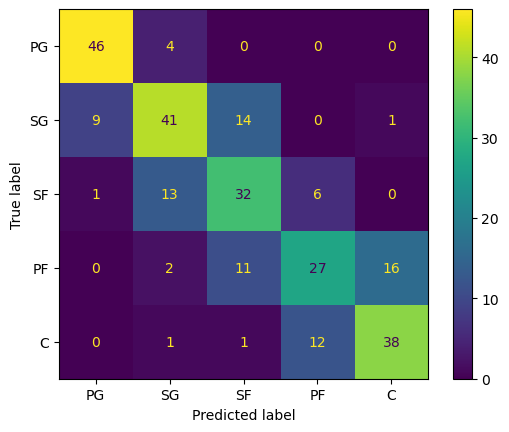

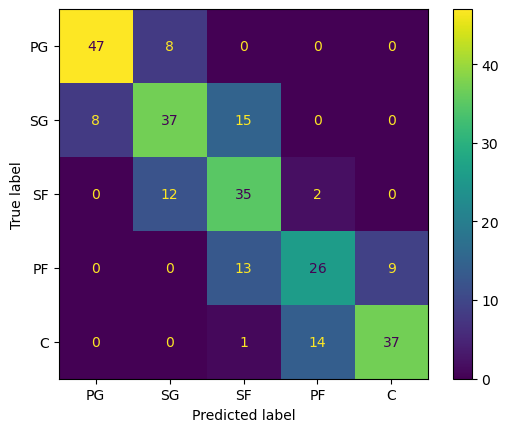

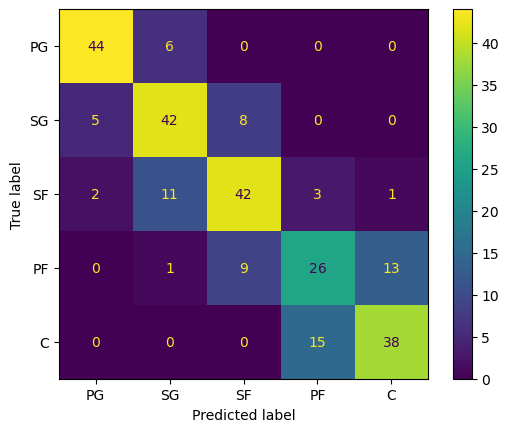

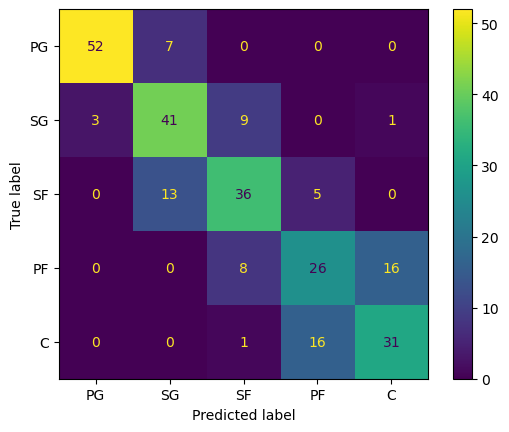

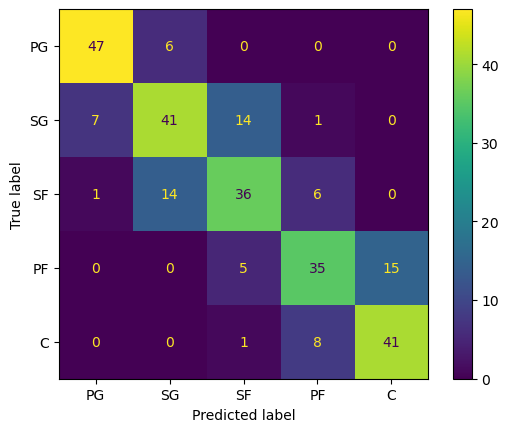

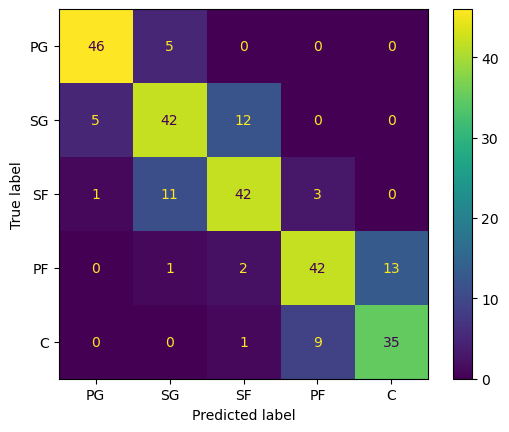

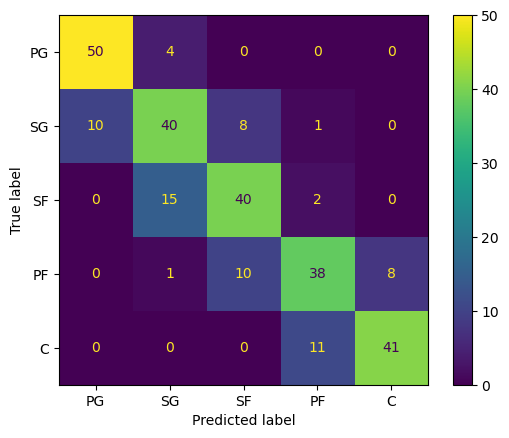

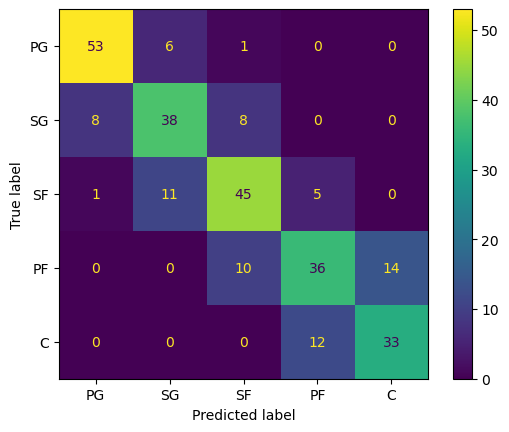

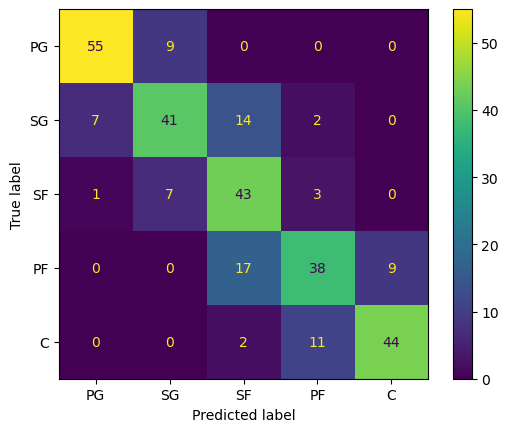

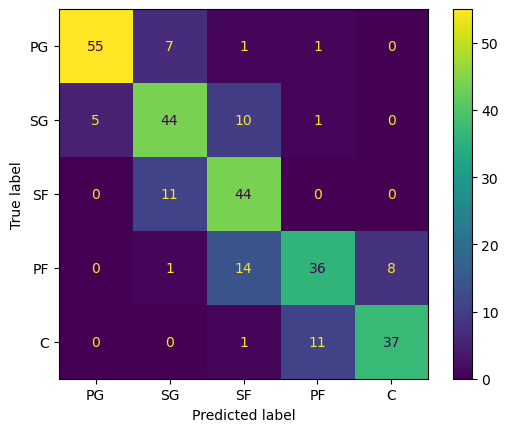

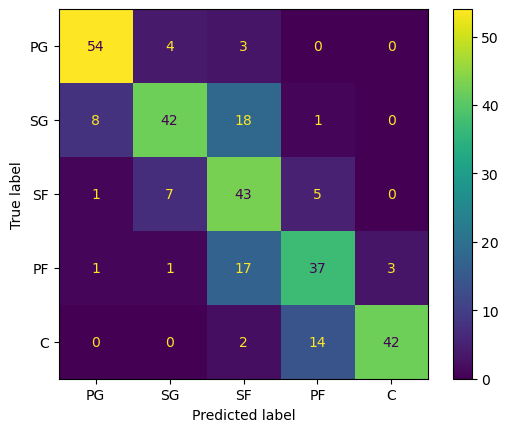

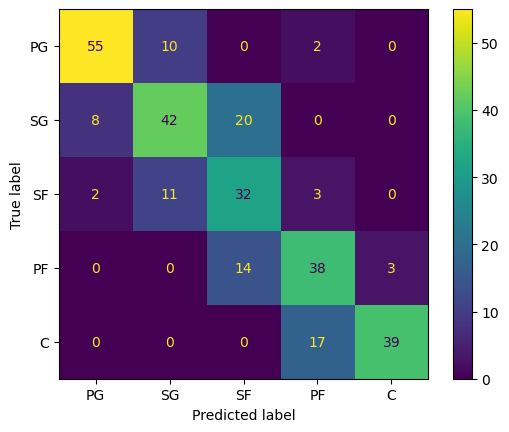

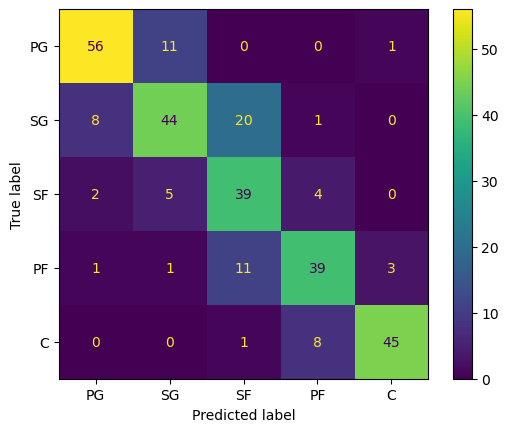

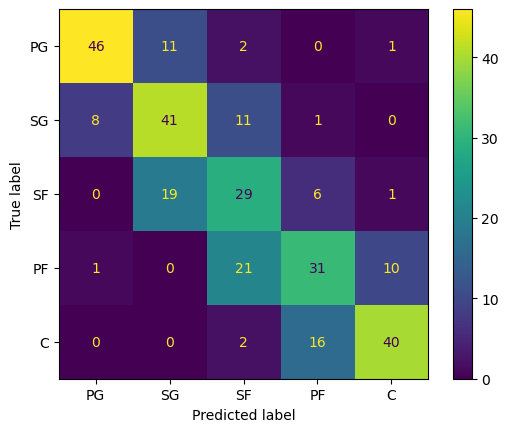

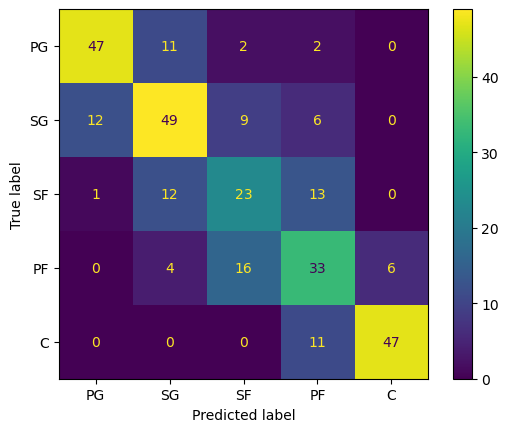

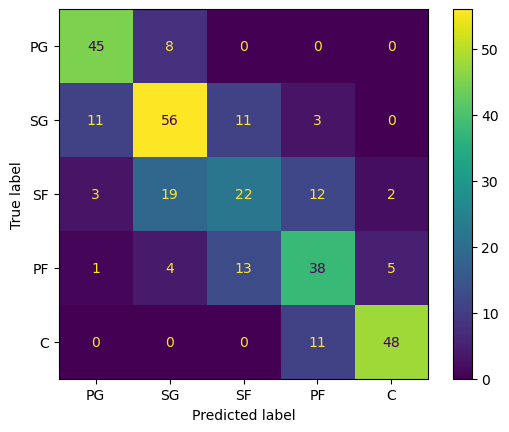

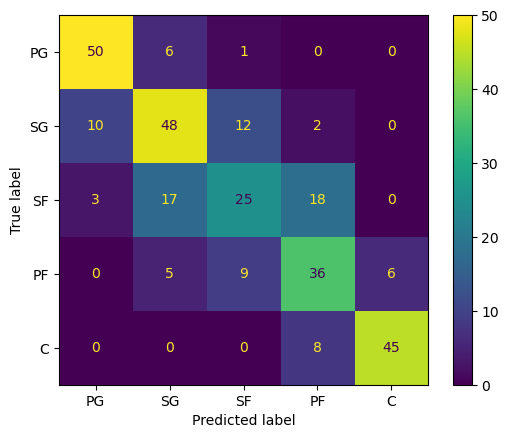

In [26]:
entropies_df, scores, feature_importances = classify_year_by_year(range(1980, 2019), 5)

<Axes: >

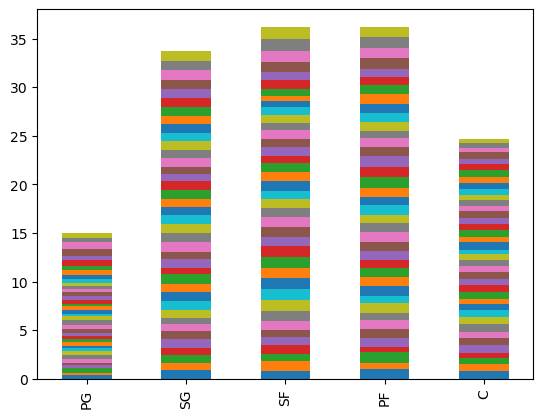

In [27]:
entropies_df.plot(kind='bar', stacked=True, legend=False)

<Axes: >

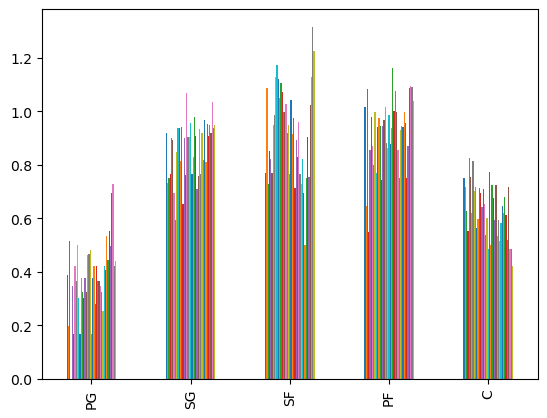

In [28]:
entropies_df.plot(kind='bar', legend=False)

<Axes: >

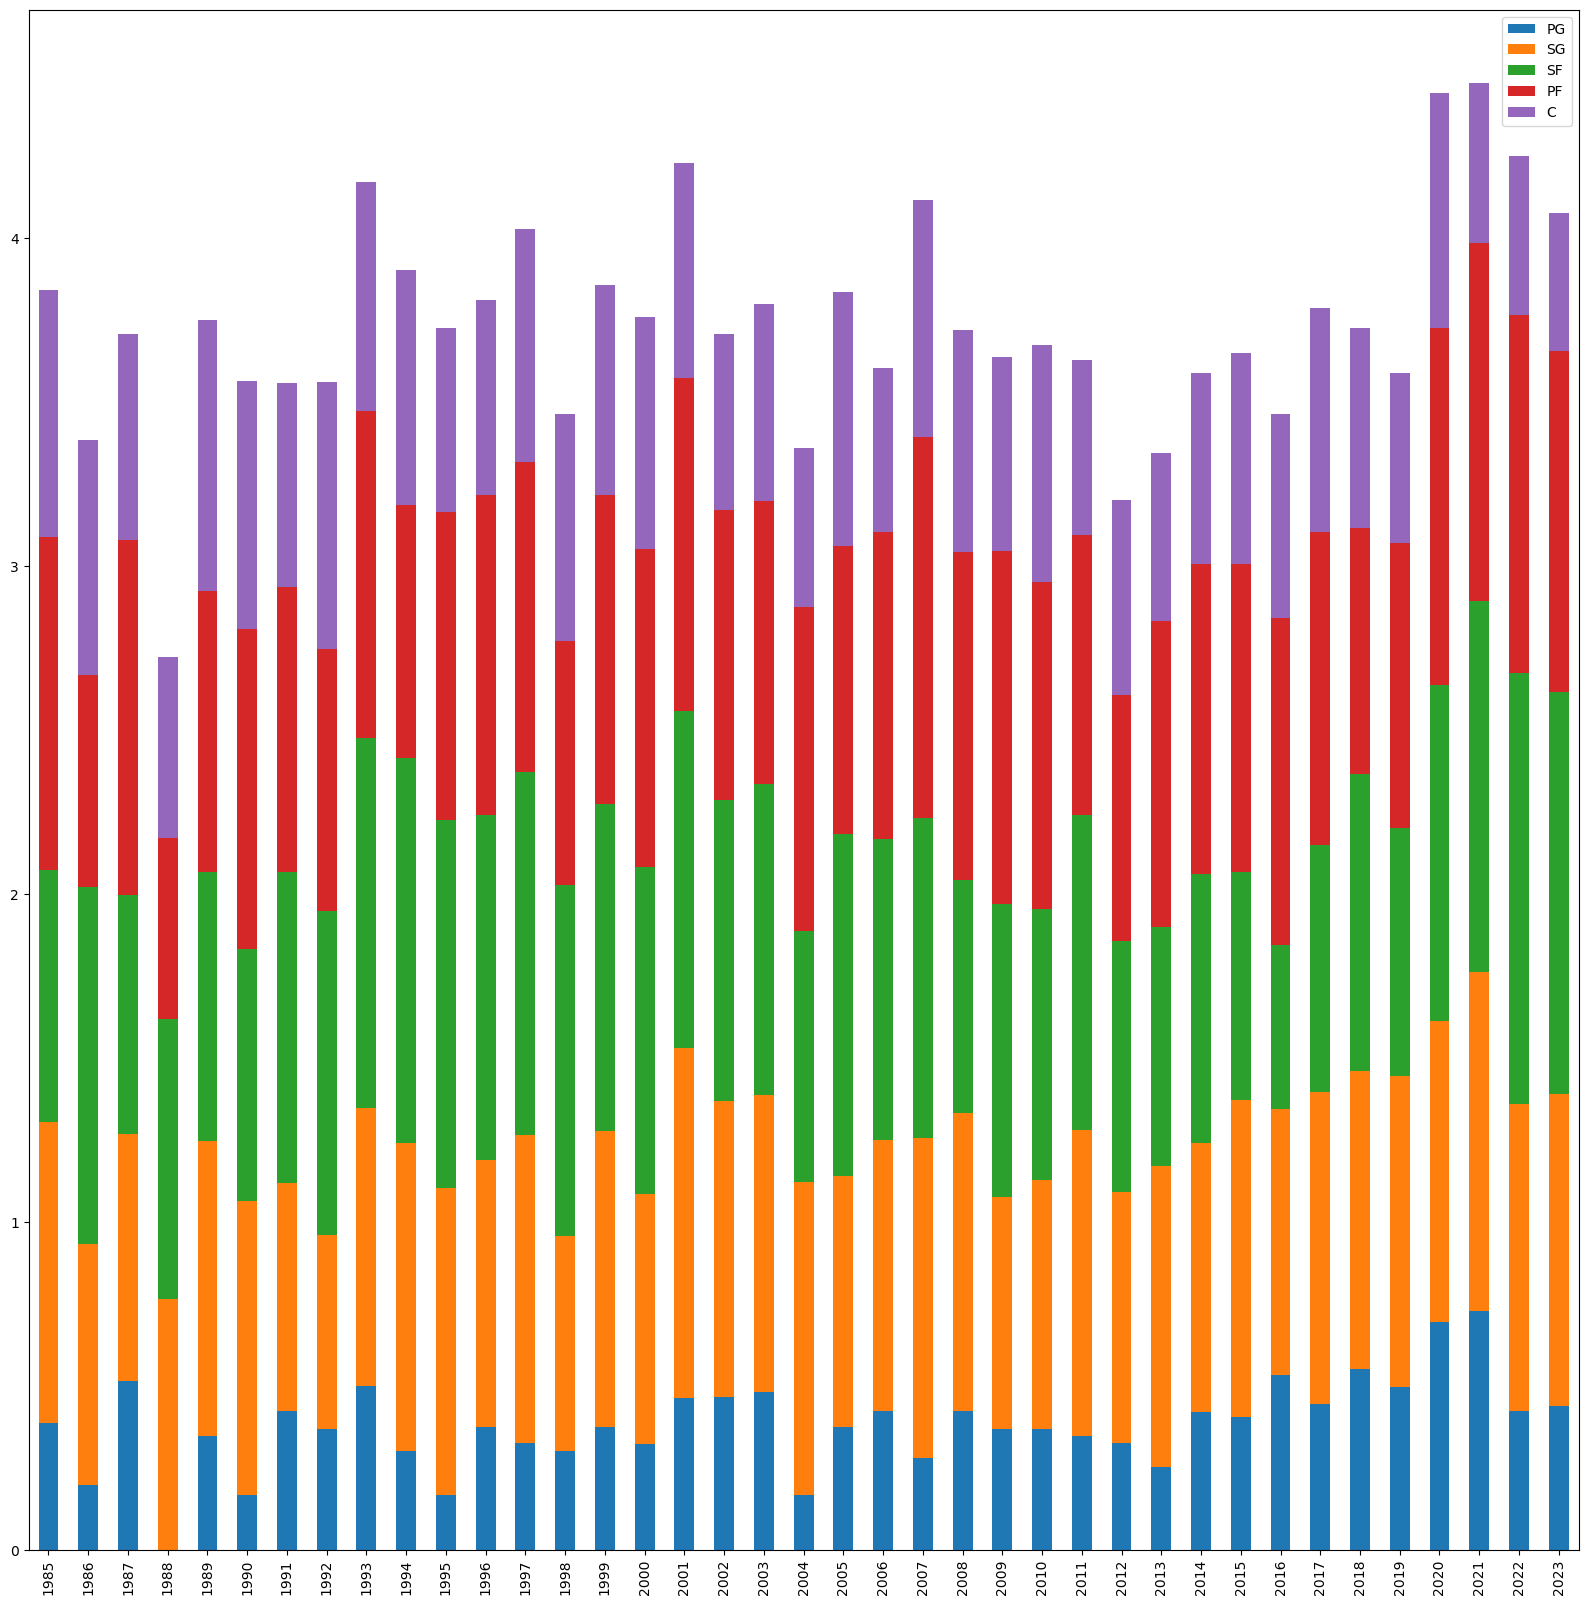

In [29]:
entropies_df.transpose().plot(kind='bar', stacked=True, figsize=(20,20))

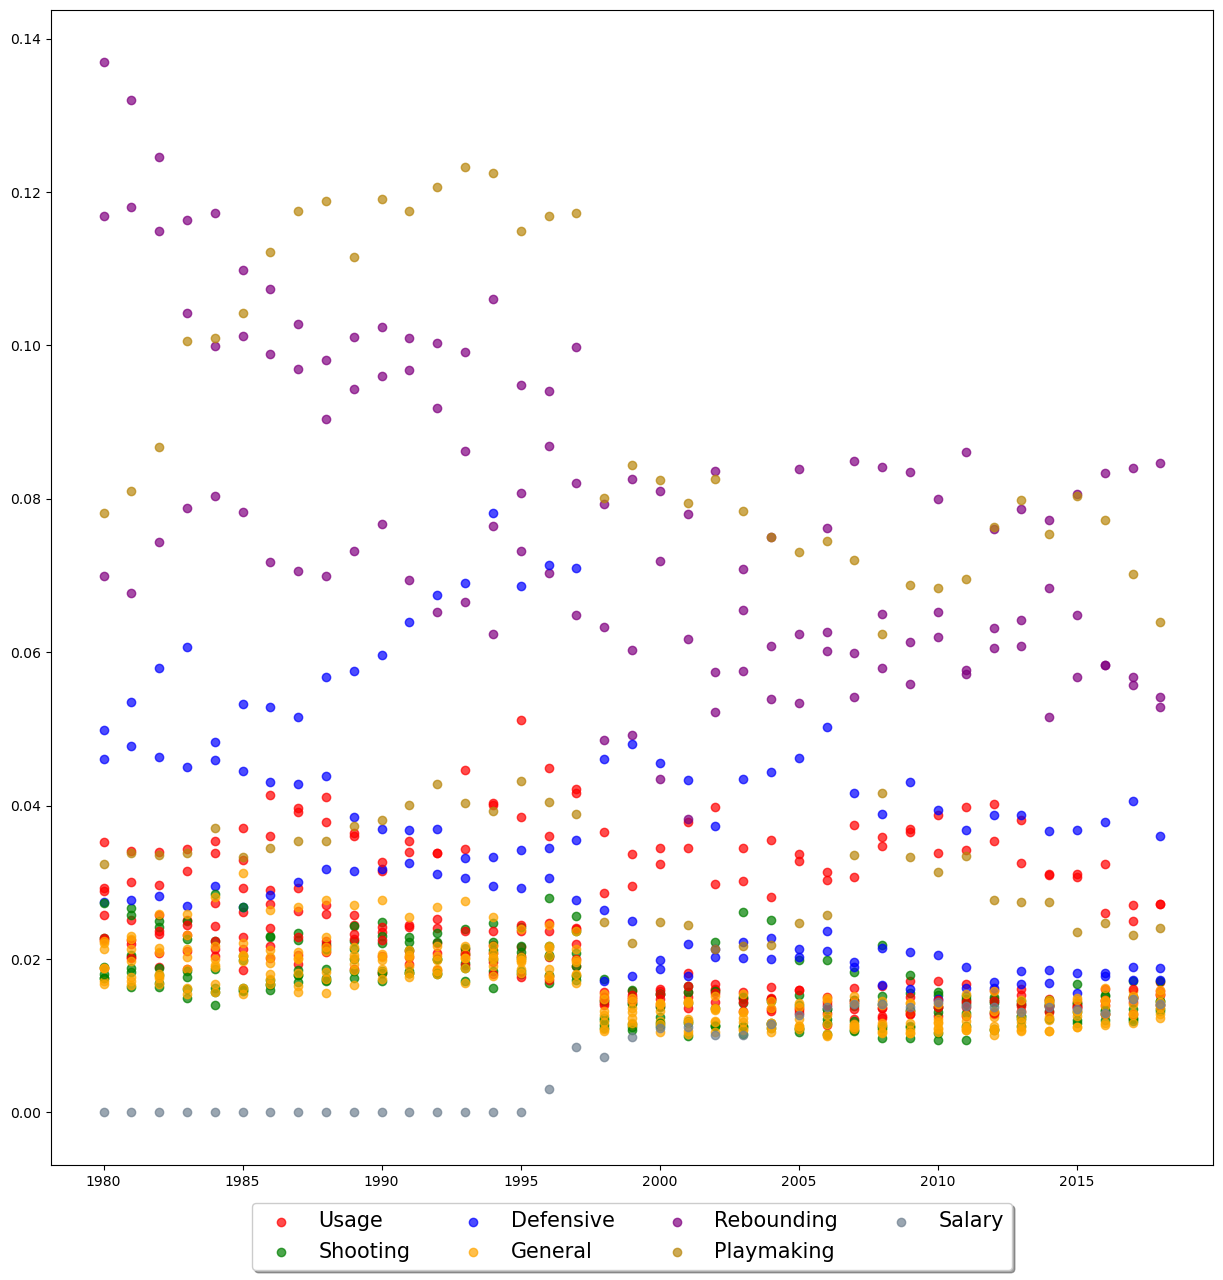

In [30]:
plt.figure(figsize=(15,15))

for idx in feature_importances.index:
    plt.scatter(feature_importances.columns, feature_importances.loc[idx], label=stats_mapper[idx], color=color_mapper[stats_mapper[idx]], alpha=0.7)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc='lower center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, prop={'size': 15})

plt.show()

In [31]:
transposed = entropies_df.transpose()
transposed.describe()

,PG,SG,SF,PF,C
count,39.000000,39.000000,39.000000,39.000000,39.000000
mean,0.383358,0.863798,0.928511,0.928031,0.632844
std,0.137921,0.106324,0.172425,0.128236,0.099306
min,0.000000,0.593928,0.500402,0.550573,0.422709
25%,0.324420,0.765655,0.768609,0.866191,0.557955
50%,0.375123,0.903532,0.948528,0.945366,0.628335
75%,0.454313,0.937019,1.047423,0.999837,0.714634
max,0.727629,1.066923,1.316260,1.160377,0.825868
